In [14]:
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import librosa

In [15]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [16]:
name = "01_technical"
motion_name = "01_technical.csv"
midi_name = "01_technical_segm.csv"
correctness_name = "01_technical_segm_correctness.csv"

# name = "02_technical"
# motion_name = "02_technical.csv"
# midi_name = "02_technical_segm.csv"
# correctness_name = "02_technical_segm_correctness.csv"

# name = "02_Bach_BWV999_exp"
# motion_name = "02_Bach_BWV999_exp.csv"
# midi_name = "02_Bach_BWV999_exp_segm.csv"
# correctness_name = "02_Bach_BWV999_exp_segm_correctness.csv"

# name = "02_Bach_BWV999_inexp"
# motion_name = "02_Bach_BWV999_inexp.csv"
# midi_name = "02_Bach_BWV999_inexp_segm.csv"
# correctness_name = "02_Bach_BWV999_inexp_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")


In [17]:
# framerate = 240
framerate = 250

#### Calculate Intensity and more for technical

In [124]:
# name = "01_technical"
# motion_name = "01_technical.csv"
# midi_name = "01_technical_segm.csv"
# correctness_name = "01_technical_segm_correctness.csv"

name = "02_technical"
motion_name = "02_technical.csv"
midi_name = "02_technical_segm.csv"
correctness_name = "02_technical_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")

In [125]:
framerate = 240
if df_motion.loc[1,"Time (ms)"]-df_motion.loc[0,"Time (ms)"] == 4:
    framerate = 250

In [126]:
LH_parts = df_metadata[ (df_metadata["motion"] == motion_name) ]["LH parts"].values[0]
RH_parts = df_metadata[ (df_metadata["motion"] == motion_name) ]["RH parts"].values[0]

In [127]:
def get_parts(parts):
    tmp = parts.split(".")
    parts = {}
    for l in tmp:
        l = l.split(" ")
        parts[l[0]] = [int(l[1]), int(l[2])]
        
    return parts

In [128]:
LH_parts = get_parts(LH_parts)
RH_parts = get_parts(RH_parts)

In [129]:
def unify_parts(LH_parts, RH_parts):
    
    total_parts = {}
    
    for key_lh, value_lh in LH_parts.items():
        
        part = key_lh[3:]
        value_rh = [value for keyrh, value in RH_parts.items() if part in keyrh][0]
        total_parts[part] = [min(value_rh[0],value_lh[0]), max(value_rh[1],value_lh[1])]
    
    return total_parts
    

In [130]:
color_hand = {
    "LH": "red",
    "RH": "green"
}

In [131]:
total_parts = unify_parts(LH_parts, RH_parts)

In [132]:
total_parts

{'CMaj': [2508, 5787],
 'Cmin': [6133, 9306],
 'CMaj_arp': [9833, 11790],
 'Cmin_arp': [12220, 14383],
 'CMaj_oct': [14520, 17865],
 'Cmin_oct': [18611, 22393]}

In [133]:
def plot_dynamics_per_part_technical(df, hand, name, LH_parts, RH_parts, 
                                             total_parts, color_hand, fit_lr = False,
                                                cv_threshold = 0.1, slight_threshold = 4*10**(-3),
                                                threshold = 10**(-2)):
    
    df = df[df["Measure"]!=0] 
    
    sns.set(rc={'figure.figsize':(70,21)},font_scale=7)
    sns.set_style("whitegrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
    
    for key, value in total_parts.items():
        fig, ax = plt.subplots()
        
        start = value[0]
        end = value[1]
        
        df_midi_hand_part = df[df["Hand"]=="LH"]
        df_midi_hand_part = df_midi_hand_part[ start <= df_midi_hand_part["Start Midi"] ]
        df_midi_hand_part = df_midi_hand_part[ df_midi_hand_part["End Midi"] <= end ] 
        start_frame = min(df_midi_hand_part["Start Midi"].values)
        
        df_midi_hand_part = df[df["Hand"]=="RH"]
        df_midi_hand_part = df_midi_hand_part[ start <= df_midi_hand_part["Start Midi"] ]
        df_midi_hand_part = df_midi_hand_part[ df_midi_hand_part["End Midi"] <= end ] 
        a = min(df_midi_hand_part["Start Midi"].values)        
        start_frame = min(start_frame,a)
        
#         print(start_frame/framerate)
        
#         start_frame = 0
        
        for hand in ["RH","LH"]:
            
            print(20*'*', "HAND: ", hand,20*'*')

            df_midi_hand_part = df[df["Hand"]==hand]

            start = value[0]
            end = value[1]

            df_midi_hand_part = df_midi_hand_part[ start <= df_midi_hand_part["Start Midi"] ]
            df_midi_hand_part = df_midi_hand_part[ df_midi_hand_part["End Midi"] <= end ]

            df_midi_hand_part.reset_index(inplace=True, drop=True)
            
            df_midi_hand_part["Start Midi"] = df_midi_hand_part["Start Midi"] - start_frame
            df_midi_hand_part["End Midi"] = df_midi_hand_part["End Midi"]- start_frame

            plt.plot(df_midi_hand_part['Start Midi'].values/framerate, df_midi_hand_part['Velocity'].values, 
                     color = color_hand[hand], alpha =0.25, linewidth = 7)
            plt.scatter(df_midi_hand_part['Start Midi'].values/framerate, df_midi_hand_part['Velocity'].values, 
                        color = color_hand[hand], alpha =0.25, s = 800)

            if fit_lr:

                notes = df_midi_hand_part["Note"].values
                notes = [librosa.note_to_hz(n) for n in notes]
                highest_note = librosa.hz_to_note(max(notes))

                highest_note_index = df_midi_hand_part[df_midi_hand_part["Note"] == highest_note].index[0]

                df_midi_hand_part_asc = df_midi_hand_part.loc[:highest_note_index,:]
                df_midi_hand_part_desc = df_midi_hand_part.loc[highest_note_index:,:]

                # plot asc
                reg = LinearRegression().fit(df_midi_hand_part_asc['Start Midi'].values.reshape(-1, 1), 
                                             df_midi_hand_part_asc['Velocity'].values)
                slope = reg.coef_
                intercept = reg.intercept_

                x = [df_midi_hand_part_asc['Start Midi'].values[0]/framerate,
                     df_midi_hand_part_asc['Start Midi'].values[-1]/framerate]
                y = [slope*df_midi_hand_part_asc['Start Midi'].values[0]+intercept, 
                     slope*df_midi_hand_part_asc['Start Midi'].values[-1]+intercept]
                plt.plot(x, y, color = color_hand[hand], label = hand, linewidth = 10)
                
                print("Part "+ key+" asc has slope "+str(slope))

                cv = df_midi_hand_part_asc.describe()['Velocity']['std']/df_midi_hand_part_asc.describe()['Velocity']['mean']
                if (cv>cv_threshold):
                    print("Cannot decide")
                else:
                    if abs(slope[0]) < slight_threshold:
                        print("Level Sound")
                    elif slope[0]>0: 
                        if slope[0]>threshold:
                            print("Crescendo")
                        else: 
                            print("Slight Crescendo")
                    elif slope[0]<0:
                        if slope[0]<-threshold:
                            print("Diminuendo")                        
                        else:
                            print("Slight Diminuendo")

                # plot desc
                reg = LinearRegression().fit(df_midi_hand_part_desc['Start Midi'].values.reshape(-1, 1), 
                                             df_midi_hand_part_desc['Velocity'].values)
                slope = reg.coef_
                intercept = reg.intercept_

                x = [df_midi_hand_part_desc['Start Midi'].values[0]/framerate, 
                     df_midi_hand_part_desc['Start Midi'].values[-1]/framerate]
                y = [slope*df_midi_hand_part_desc['Start Midi'].values[0] +intercept, 
                     slope*df_midi_hand_part_desc['Start Midi'].values[-1]+ intercept]
                plt.plot(x, y, color = color_hand[hand], label = hand, linewidth = 10)           
                
                print("Part "+ key+" desc has slope "+str(slope))

                cv = df_midi_hand_part_desc.describe()['Velocity']['std']/df_midi_hand_part_desc.describe()['Velocity']['mean']
                if (cv>cv_threshold):
                    print("Cannot decide")
                else:
                    if abs(slope[0]) < slight_threshold:
                        print("Level Sound")
                    elif slope[0]>0: 
                        if slope[0]>threshold:
                            print("Crescendo")
                        else: 
                            print("Slight Crescendo")
                    elif slope[0]<0:
                        if slope[0]<-threshold:
                            print("Diminuendo")                        
                        else:
                            print("Slight Diminuendo")


        plt.ylim(20,75)
        ax.yaxis.grid(False) # Hide the horizontal gridlines
        ax.xaxis.grid(True) # Show the vertical gridlines    
        plt.title("Note Loudness - Technical " + key + " (Pianist " + name[1] + ")", y = 1.05)
        plt.xlabel('Time (sec)')
        plt.ylabel('Loudness (MIDI Velocity)')
        ax.legend()

        
        
        legend_without_duplicate_labels(ax)
        plt.savefig("./plots/dynamics/intensity_per_part"+ name+ "_"+key+".png")
        plt.show()
        plt.close()  

******************** HAND:  RH ********************
Part CMaj asc has slope [0.00841095]
Cannot decide
Part CMaj desc has slope [-0.0022622]
Level Sound
******************** HAND:  LH ********************
Part CMaj asc has slope [0.01080162]
Cannot decide
Part CMaj desc has slope [-0.00478067]
Cannot decide


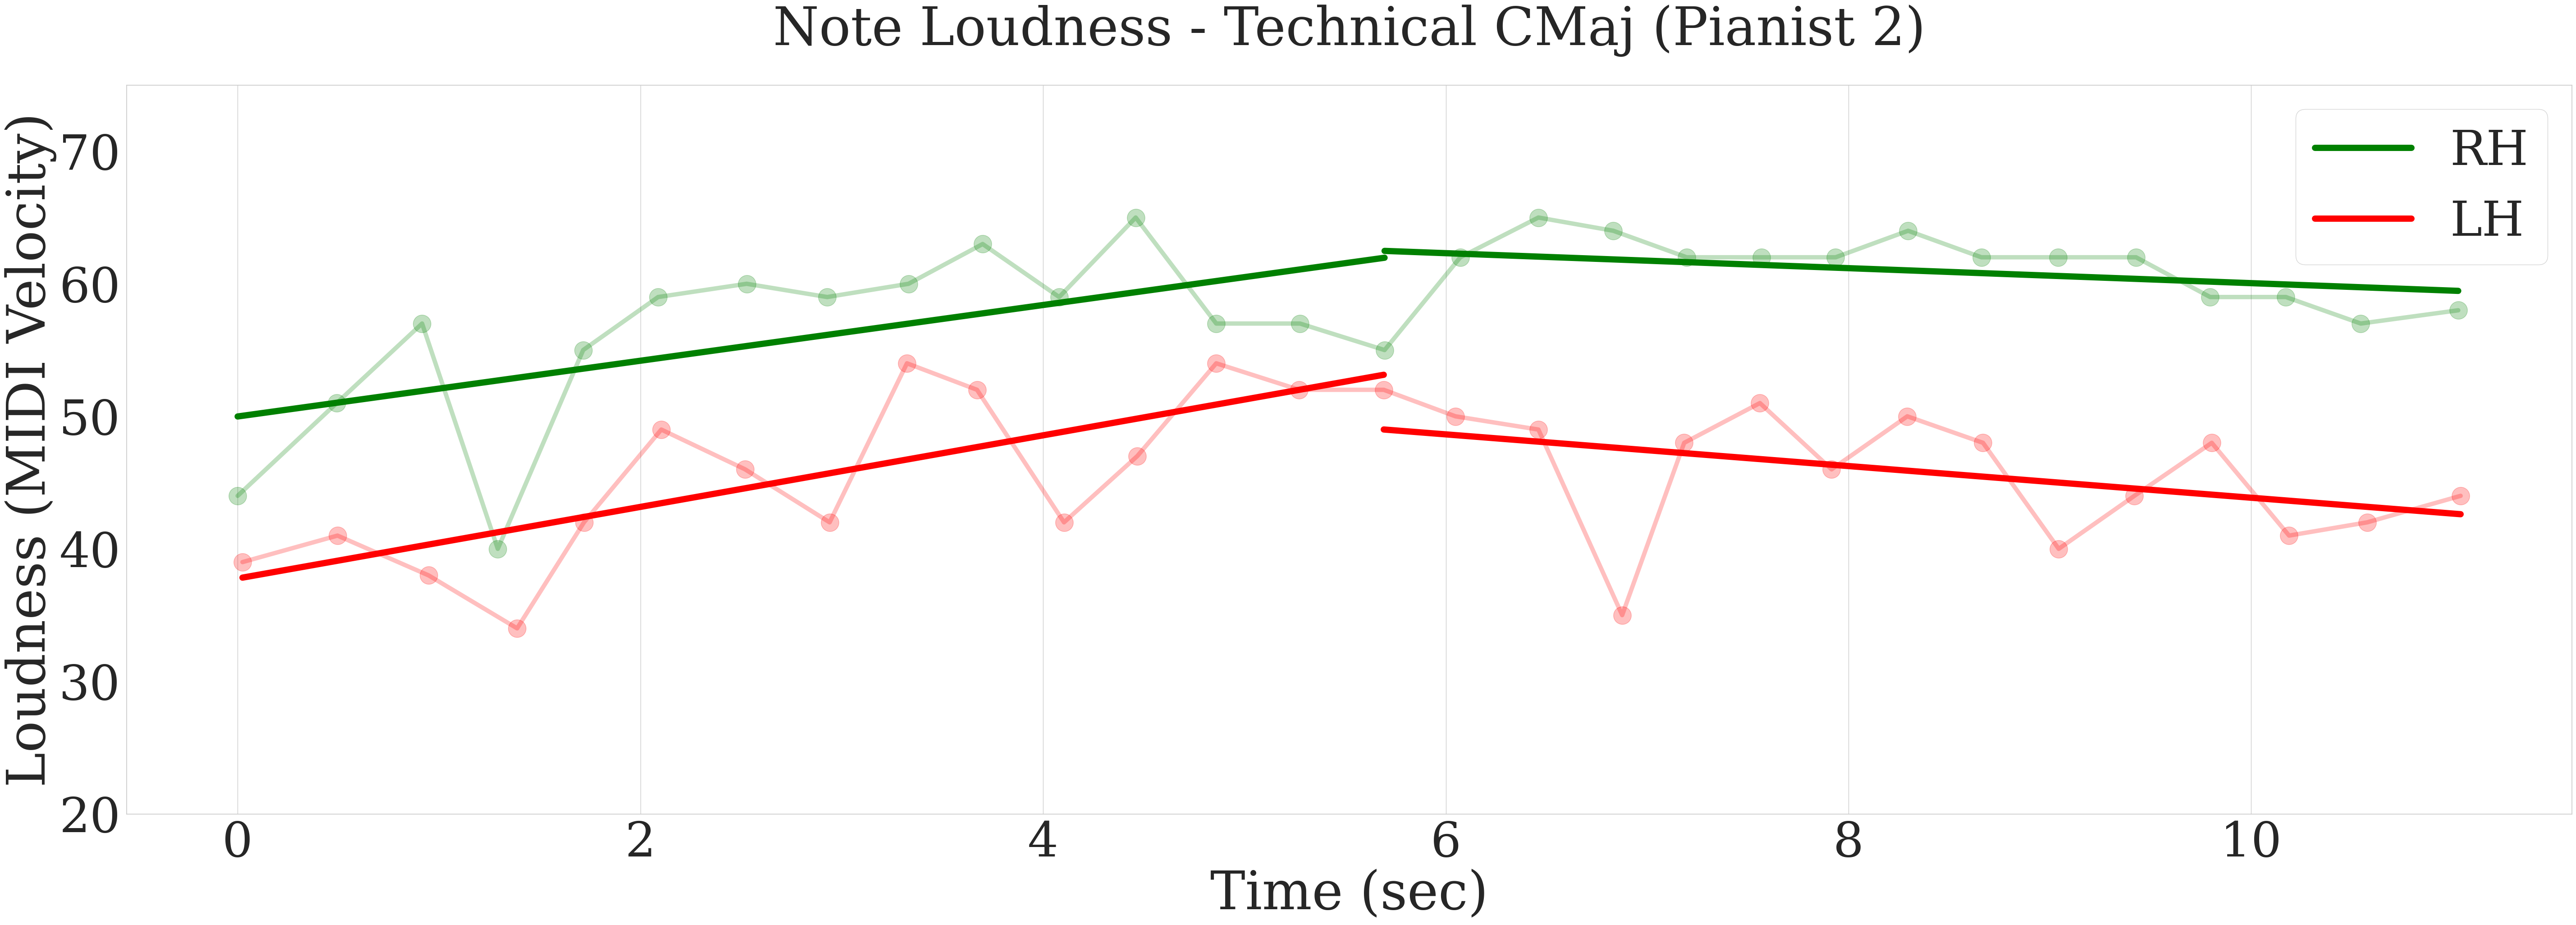

******************** HAND:  RH ********************
Part Cmin asc has slope [0.00826577]
Slight Crescendo
Part Cmin desc has slope [-0.00963549]
Slight Diminuendo
******************** HAND:  LH ********************
Part Cmin asc has slope [0.00772012]
Slight Crescendo
Part Cmin desc has slope [-0.00735891]
Slight Diminuendo


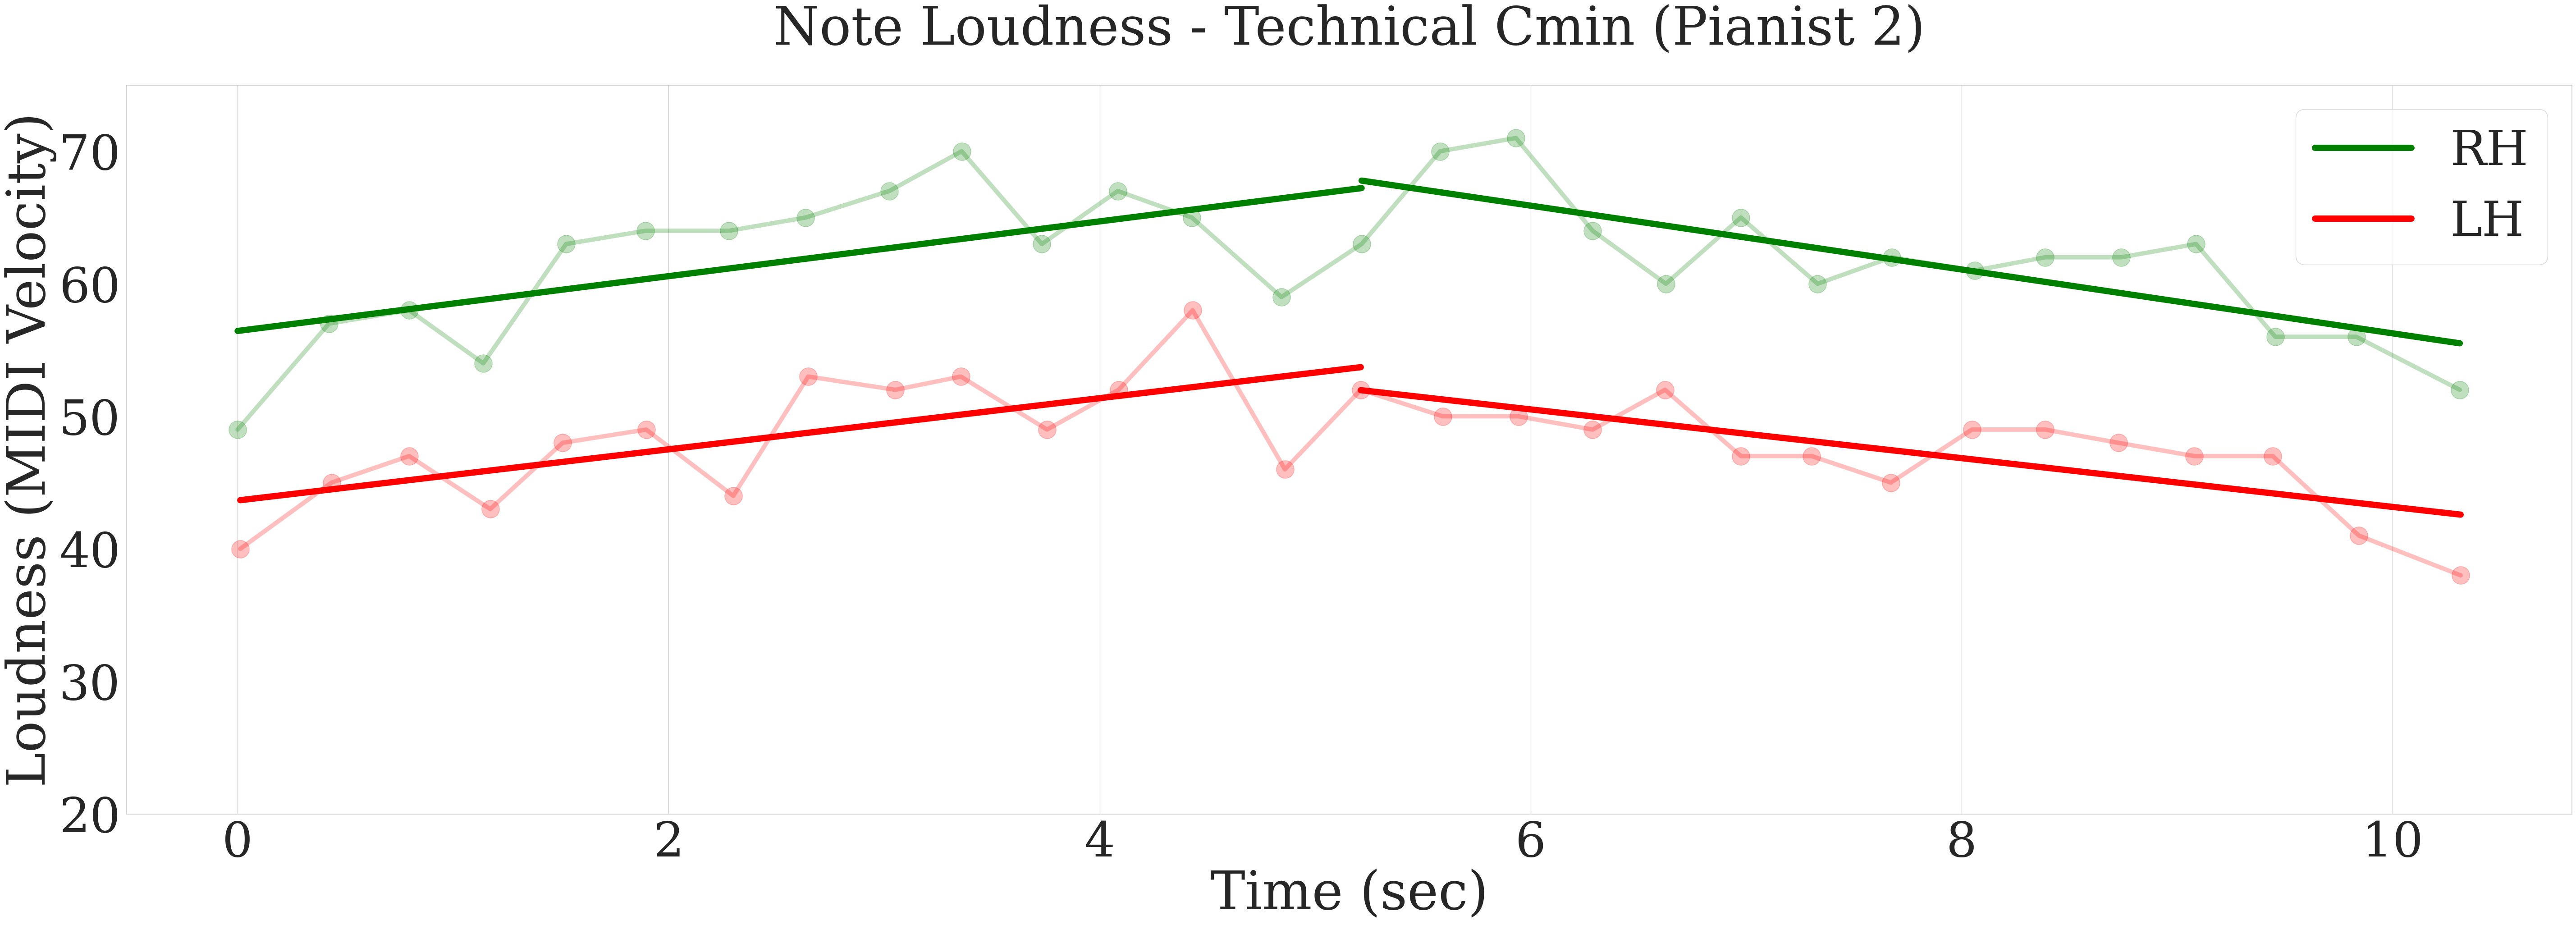

******************** HAND:  RH ********************
Part CMaj_arp asc has slope [0.04763543]
Cannot decide
Part CMaj_arp desc has slope [-0.0374205]
Cannot decide
******************** HAND:  LH ********************
Part CMaj_arp asc has slope [0.02071578]
Crescendo
Part CMaj_arp desc has slope [-0.0214896]
Cannot decide


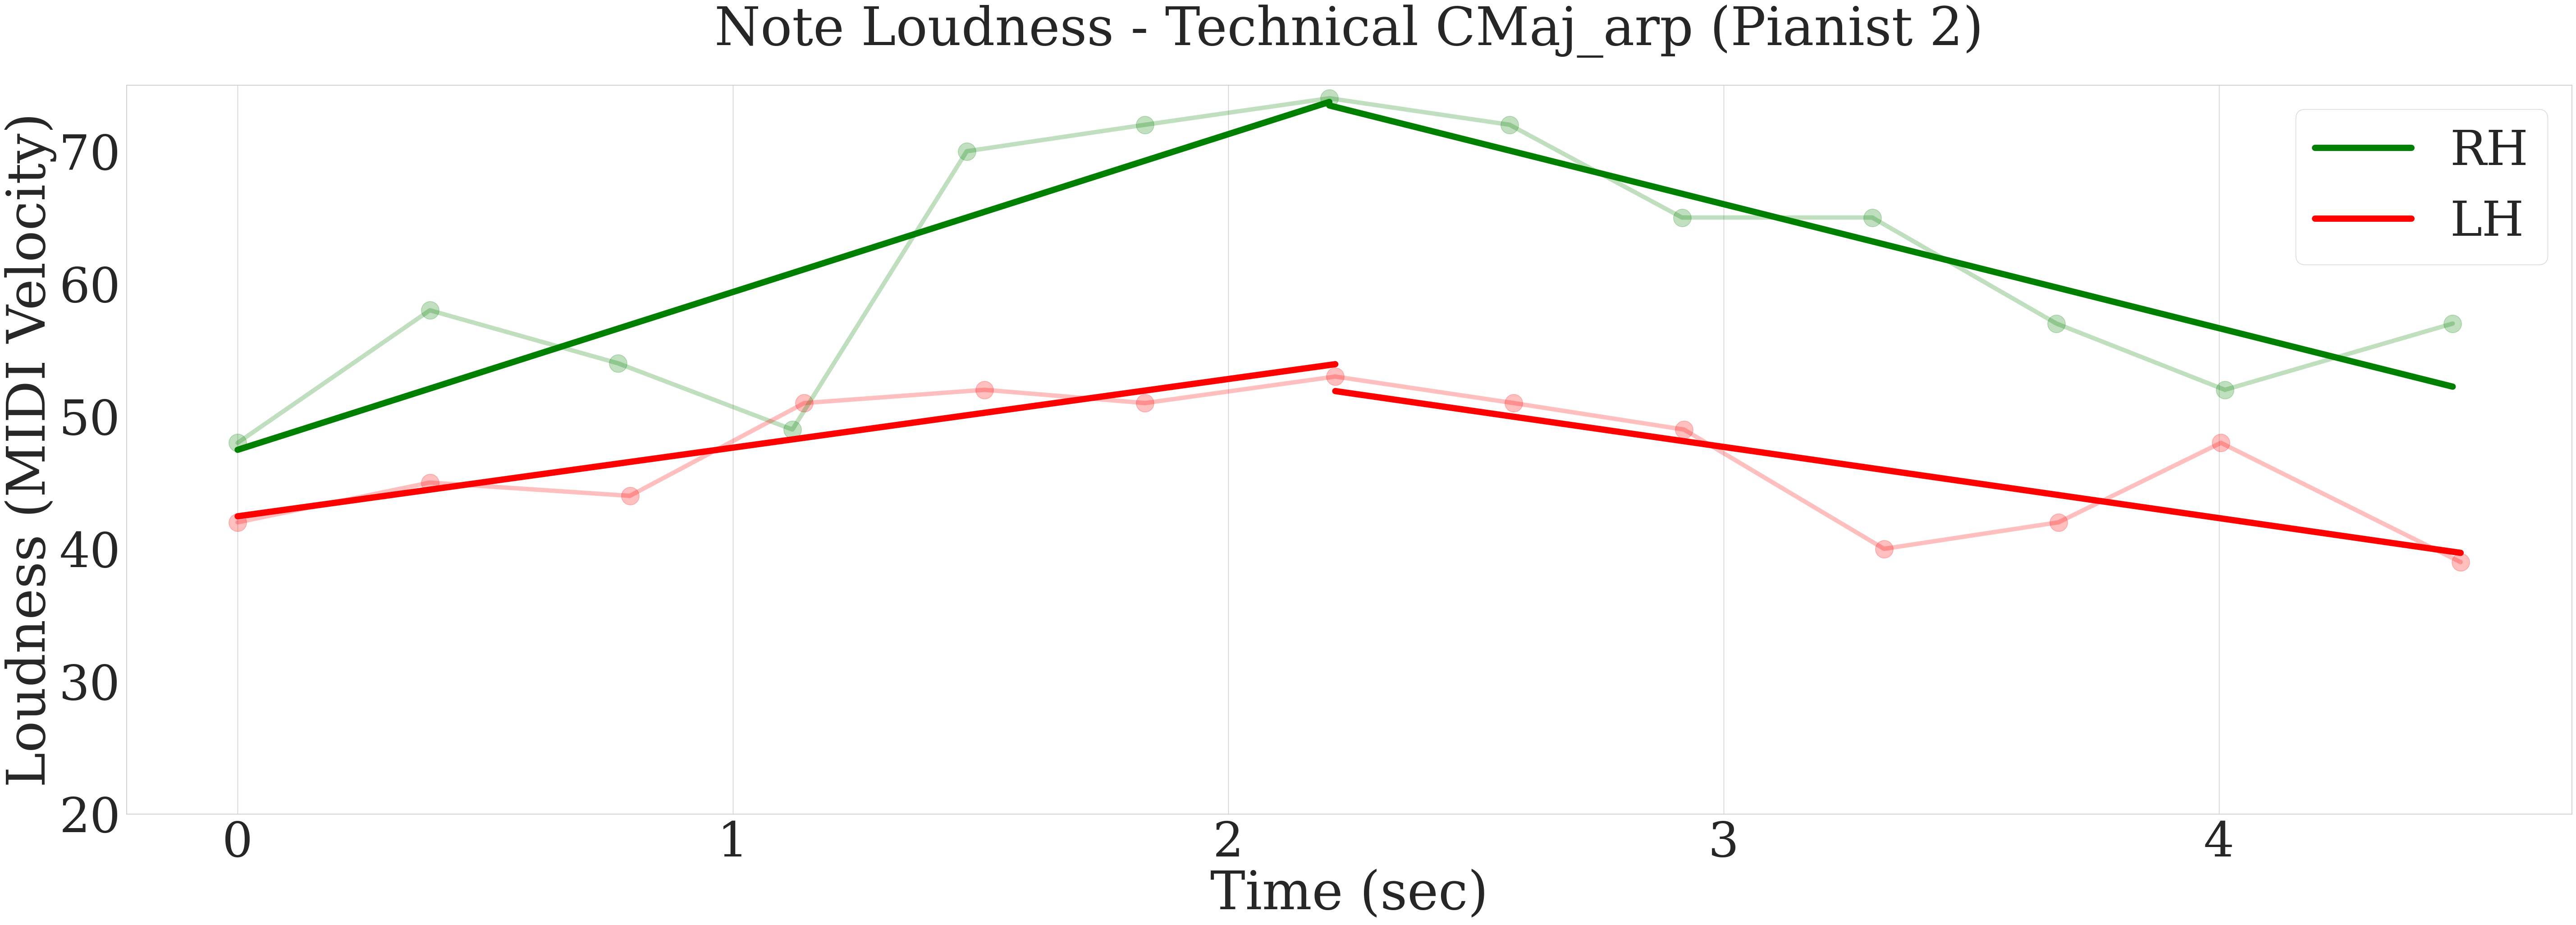

******************** HAND:  RH ********************
Part Cmin_arp asc has slope [0.03264868]
Cannot decide
Part Cmin_arp desc has slope [-0.03038639]
Cannot decide
******************** HAND:  LH ********************
Part Cmin_arp asc has slope [0.02661387]
Cannot decide
Part Cmin_arp desc has slope [-0.008741]
Slight Diminuendo


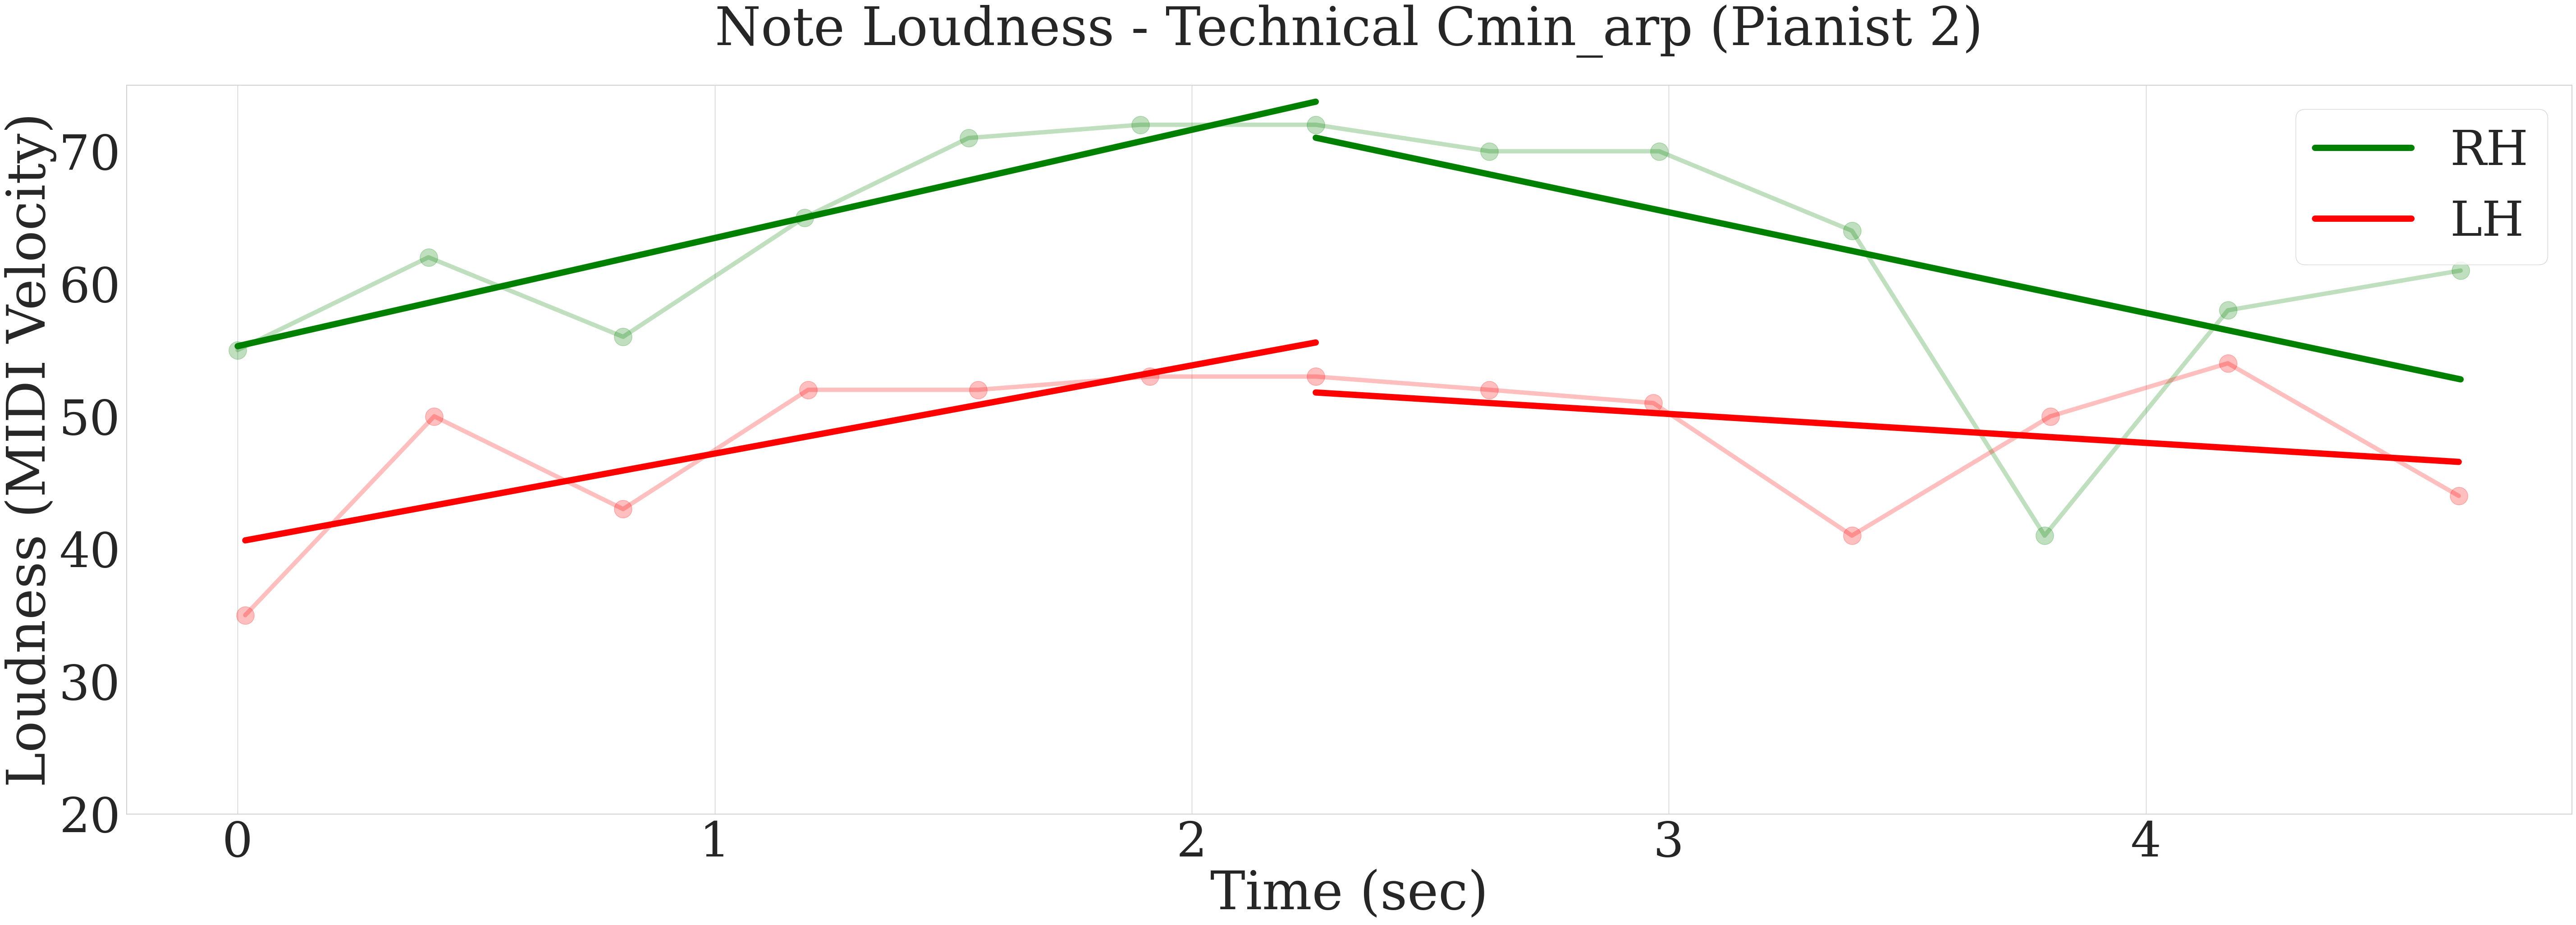

******************** HAND:  RH ********************
Part CMaj_oct asc has slope [0.00527231]
Cannot decide
Part CMaj_oct desc has slope [-0.00161593]
Cannot decide
******************** HAND:  LH ********************
Part CMaj_oct asc has slope [0.0022728]
Cannot decide
Part CMaj_oct desc has slope [-0.0036676]
Cannot decide


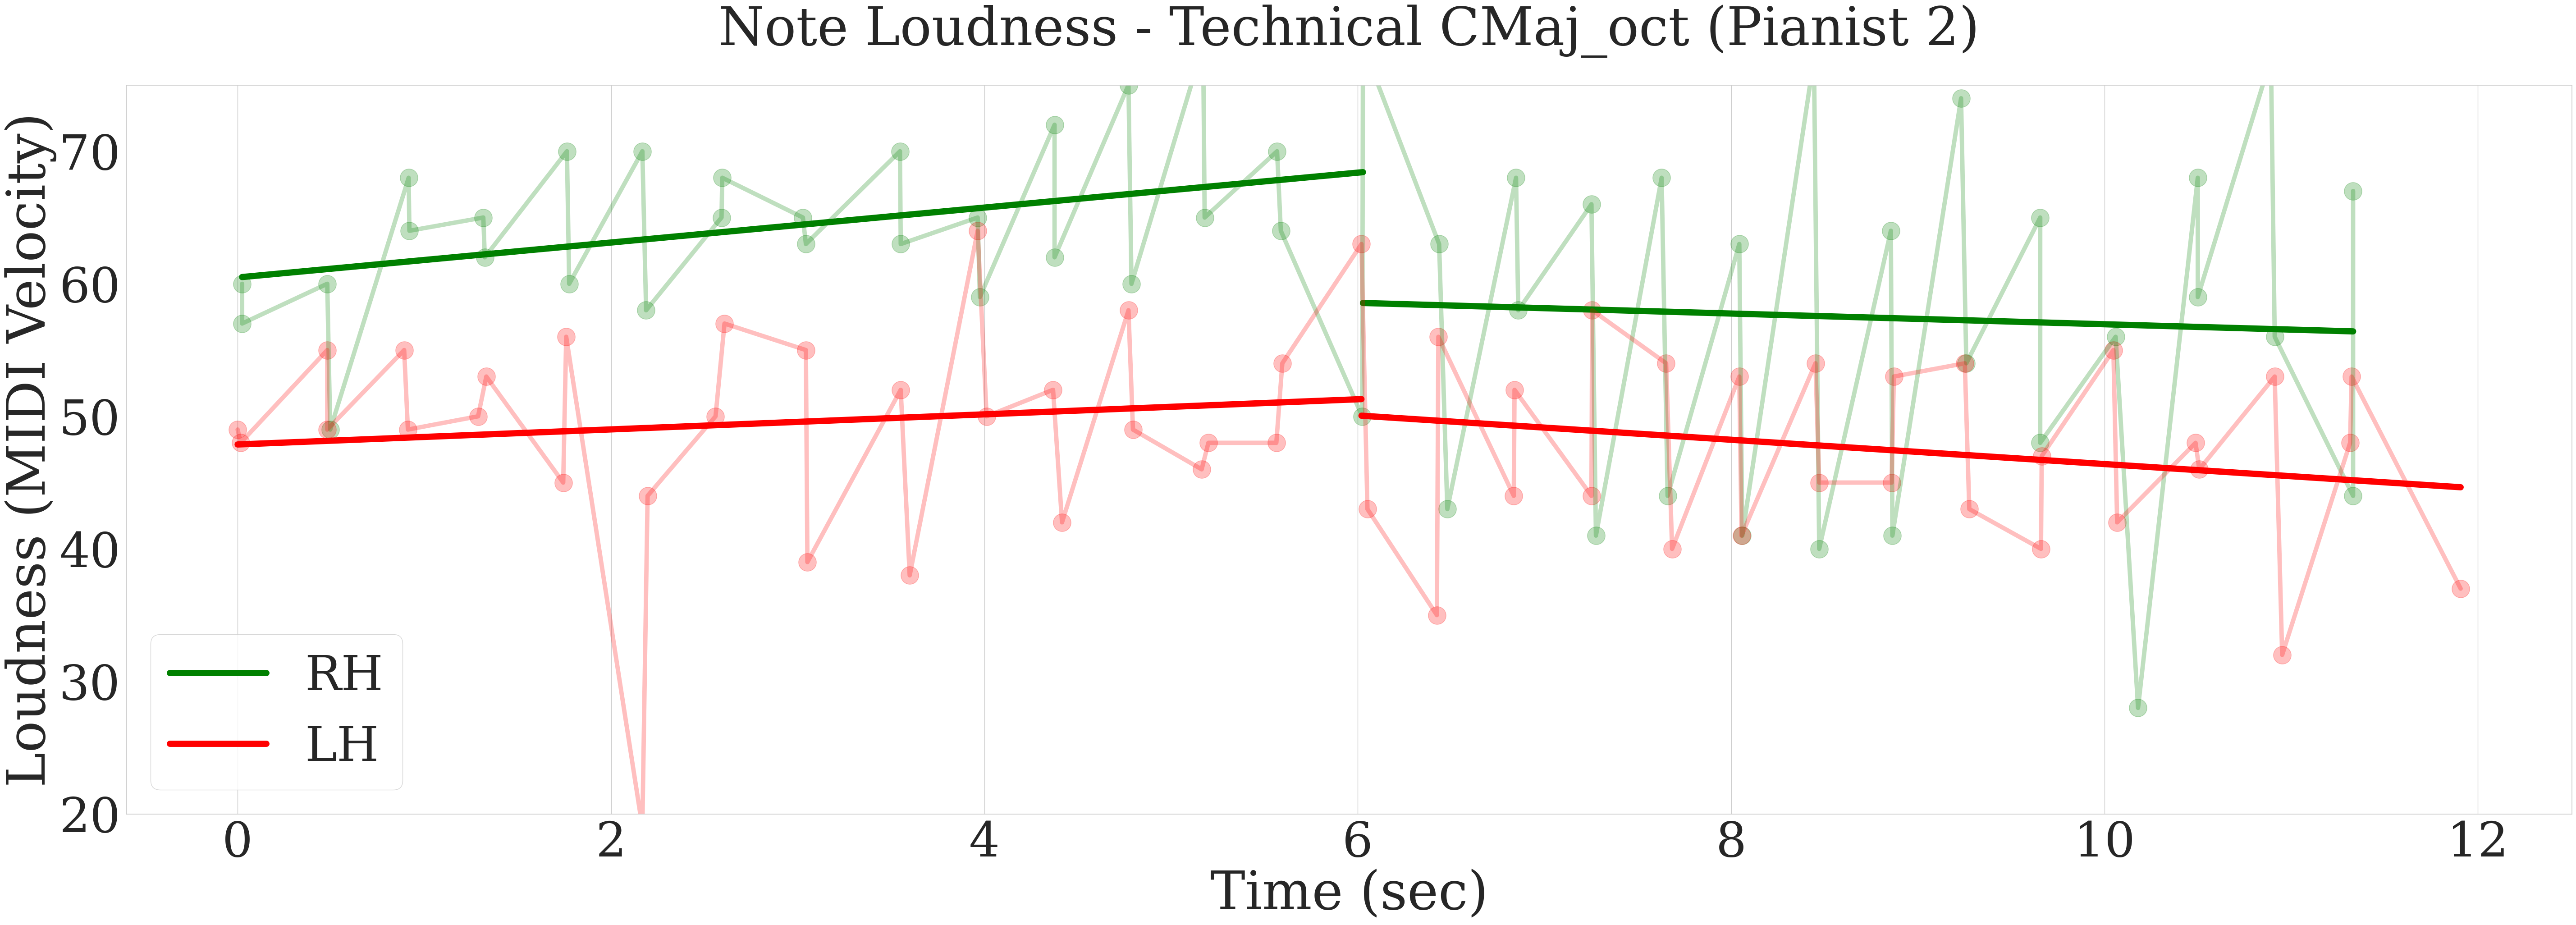

******************** HAND:  RH ********************
Part Cmin_oct asc has slope [0.00442585]
Cannot decide
Part Cmin_oct desc has slope [-0.00470138]
Cannot decide
******************** HAND:  LH ********************
Part Cmin_oct asc has slope [0.00083151]
Cannot decide
Part Cmin_oct desc has slope [-0.00302851]
Cannot decide


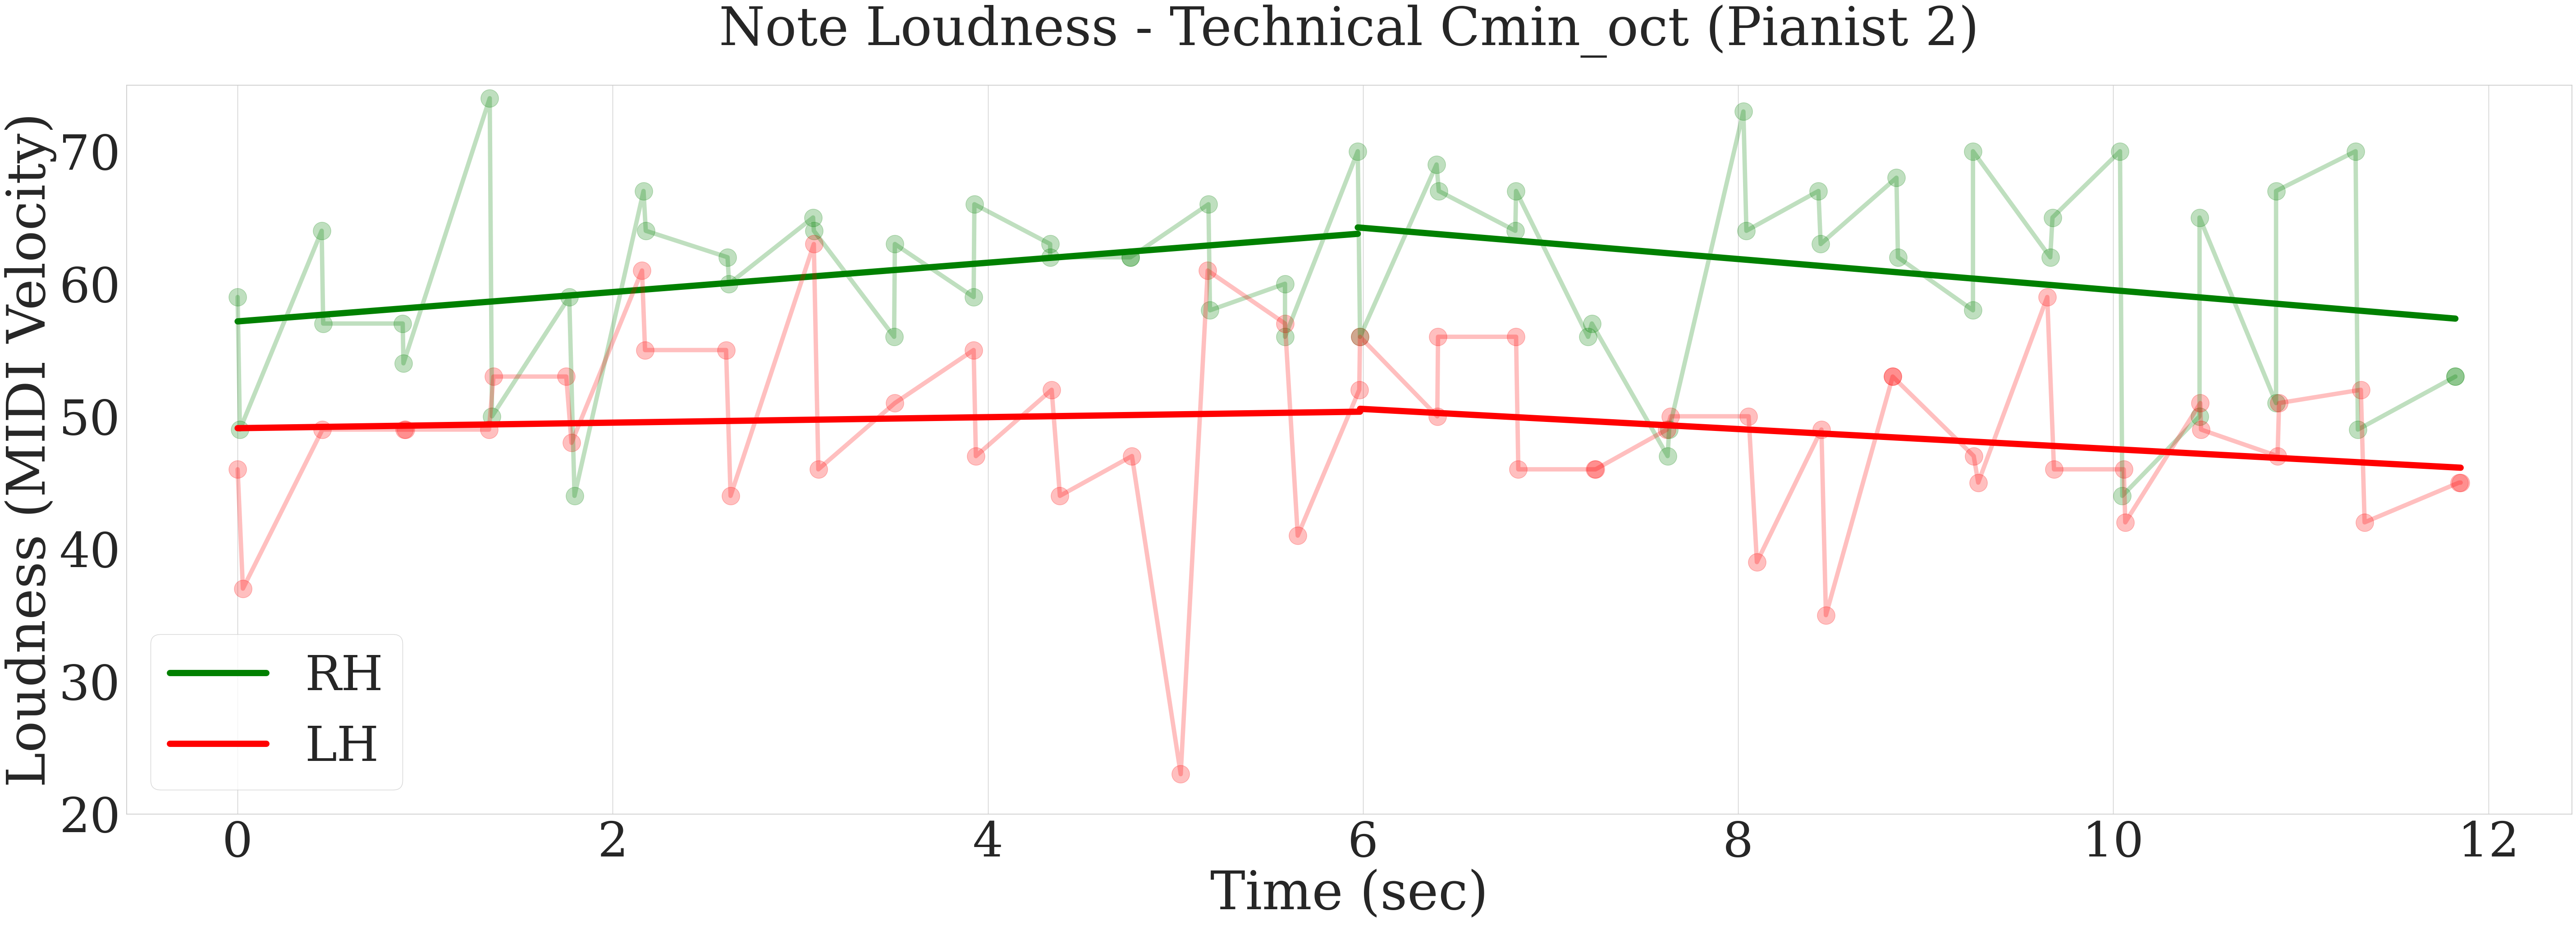

In [134]:
plot_dynamics_per_part_technical(df_midi, "LH", name, LH_parts, RH_parts, 
                                         total_parts, color_hand, fit_lr = True)

#### Bach

In [211]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [212]:
# name = "02_Bach_BWV999_exp"
# motion_name = "02_Bach_BWV999_exp.csv"
# midi_name = "02_Bach_BWV999_exp_segm.csv"
# correctness_name = "02_Bach_BWV999_exp_segm_correctness.csv"

name = "02_Bach_BWV999_inexp"
motion_name = "02_Bach_BWV999_inexp.csv"
midi_name = "02_Bach_BWV999_inexp_segm.csv"
correctness_name = "02_Bach_BWV999_inexp_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")

In [213]:
framerate = 240
if df_motion.loc[1,"Time (ms)"]-df_motion.loc[0,"Time (ms)"] == 4:
    framerate = 250

In [214]:
bach_parts = {
    "Part 1 (m. 1-7)": (1,7), # first argument of tuple is measure, second is note
    "Part 2 (m. 7-13)": (7,13),
    "Part 3 (m. 13-16)": (13,16),
    "Part 4 (m. 16-20)": (16,20),
}

type_dict = {
    "02_Bach_BWV999_exp" : "Expressive",
    "02_Bach_BWV999_inexp" : "Inexpressive"
}

In [215]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return ax.legend(*zip(*unique), loc = "lower right")

In [216]:
def plot_dynamics_per_part_bach(df, name, bach_parts, color_hand, fit_lr = False, cv_threshold = 0.1, 
                                slight_threshold = 4*10**(-3), threshold = 10**(-2)):
    
    df = df[df["Measure"]!=0] 
    
    sns.set(rc={'figure.figsize':(40,15)},font_scale=5)
    sns.set_style("whitegrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
    
    
    fig, ax = plt.subplots()
    plt.rcParams["font.family"] = "Times New Roman"
    
    start_time = df["Start Midi"].values[0]
    
    for key, value in bach_parts.items():
        

        
        for hand in ["RH","LH"]:
            
            print(20*'*', "HAND: ", hand,20*'*')

            df_midi_hand_part = df[df["Hand"]==hand]

            start_measure = value[0]
            end_measure = value[1]
                                
            # right hand
            df_midi_hand_part = df_midi_hand_part[df_midi_hand_part['Measure']>=start_measure]
            df_midi_hand_part = df_midi_hand_part[df_midi_hand_part['Measure']<=end_measure]
            df_midi_hand_part.reset_index(inplace=True, drop=True)
                   
                
                
            number_of_notes_at_last_measure = df_midi_hand_part[df_midi_hand_part["Measure"]==end_measure].shape[0]
            df_midi_hand_part = df_midi_hand_part.loc[:df_midi_hand_part.shape[0] - number_of_notes_at_last_measure,:]

            

            
            start_rh = min(df_midi_hand_part['Start Midi'])
            end_rh = max(df_midi_hand_part['Start Midi'])

            df_midi_hand_part = df_midi_hand_part[df_midi_hand_part['Start Midi']>=start_rh]
            df_midi_hand_part = df_midi_hand_part[df_midi_hand_part['Start Midi']<=end_rh]

            df_midi_hand_part.reset_index(inplace=True, drop=True)
            
            df_midi_hand_part['Start Midi'] -= start_time

#             if (hand=="LH"):
#                 plt.axvline(df_midi_hand_part['Start Midi'].values[0]/framerate, ls='--', color = 'b')
#             elif (hand=="RH"):
#                 plt.axvline(df_midi_hand_part['Start Midi'].values[-1]/framerate, ls='--', color = 'b', alpha = 0.5)
            
            
            df_midi_hand_part_lh = df_midi_hand_part[df_midi_hand_part["Hand"]=="LH"]
            df_midi_hand_part_rh = df_midi_hand_part[df_midi_hand_part["Hand"]=="RH"]
            
            
            
            
            plt.plot(df_midi_hand_part_lh['Start Midi'].values/framerate, df_midi_hand_part_lh['Velocity'].values, 
                     color = 'red', alpha = 0.25)
            plt.scatter(df_midi_hand_part_lh['Start Midi'].values/framerate, df_midi_hand_part_lh['Velocity'].values, 
                        color='red', alpha = 0.25, s = 100)
            
            plt.plot(df_midi_hand_part_rh['Start Midi'].values/framerate, df_midi_hand_part_rh['Velocity'].values, 
                     color = 'green', alpha = 0.25)            
            plt.scatter(df_midi_hand_part_rh['Start Midi'].values/framerate, df_midi_hand_part_rh['Velocity'].values, 
                        color='green', alpha = 0.25, s = 100)            
            
#             plt.scatter(df_midi_hand_part['Start Midi'].values, df_midi_hand_part['Velocity'].values, 
#                         color='lightgray', s = 100)

            if fit_lr:
                
                # plot asc
                reg = LinearRegression().fit(df_midi_hand_part['Start Midi'].values.reshape(-1, 1)/framerate, 
                                             df_midi_hand_part['Velocity'].values)
                slope = reg.coef_
                intercept = reg.intercept_

                x = [df_midi_hand_part['Start Midi'].values[0]/framerate, df_midi_hand_part['Start Midi'].values[-1]/framerate]
                y = [slope*df_midi_hand_part['Start Midi'].values[0]/framerate+intercept, 
                     slope*df_midi_hand_part['Start Midi'].values[-1]/framerate+intercept]
                plt.plot(x, y, color = color_hand[hand], label = hand, linewidth = 5)
                
                print("Part "+ key+" asc has slope "+str(slope))

                cv = df_midi_hand_part.describe()['Velocity']['std']/df_midi_hand_part.describe()['Velocity']['mean']
                if (cv>cv_threshold):
                    print("Cannot decide")
                else:
                    if abs(slope[0]) < slight_threshold:
                        print("Level Sound")
                    elif slope[0]>0: 
                        if slope[0]>threshold:
                            print("Crescendo")
                        else: 
                            print("Slight Crescendo")
                    elif slope[0]<0:
                        if slope[0]<-threshold:
                            print("Diminuendo")                        
                        else:
                            print("Slight Diminuendo")                


    plt.ylim(30,85)
    
    ax.yaxis.grid(False) # Hide the horizontal gridlines
    ax.xaxis.grid(True) # Show the vertical gridlines    
    plt.title("Dynamic Variation per Part per Hand - Prelude, "+str(type_dict[name]) +" (Pianist " + name[1] + ")", y=1.08)
    plt.xlabel('Time (sec)')
    plt.ylabel('Intensity (MIDI Velocity)')
    



    legend_without_duplicate_labels(ax)
    plt.savefig("./plots/dynamics/intensity_per_part_"+ name+ "_per_hand.png")
    plt.show()
    plt.close()  

******************** HAND:  RH ********************
Part Part 1 (m. 1-7) asc has slope [-0.20178698]
Diminuendo
******************** HAND:  LH ********************
Part Part 1 (m. 1-7) asc has slope [0.87579812]
Cannot decide
******************** HAND:  RH ********************
Part Part 2 (m. 7-13) asc has slope [0.34161494]
Crescendo
******************** HAND:  LH ********************
Part Part 2 (m. 7-13) asc has slope [-0.04352375]
Diminuendo
******************** HAND:  RH ********************
Part Part 3 (m. 13-16) asc has slope [0.55300697]
Crescendo
******************** HAND:  LH ********************
Part Part 3 (m. 13-16) asc has slope [-0.73346156]
Diminuendo
******************** HAND:  RH ********************
Part Part 4 (m. 16-20) asc has slope [-0.24481434]
Diminuendo
******************** HAND:  LH ********************
Part Part 4 (m. 16-20) asc has slope [-0.39392322]
Cannot decide


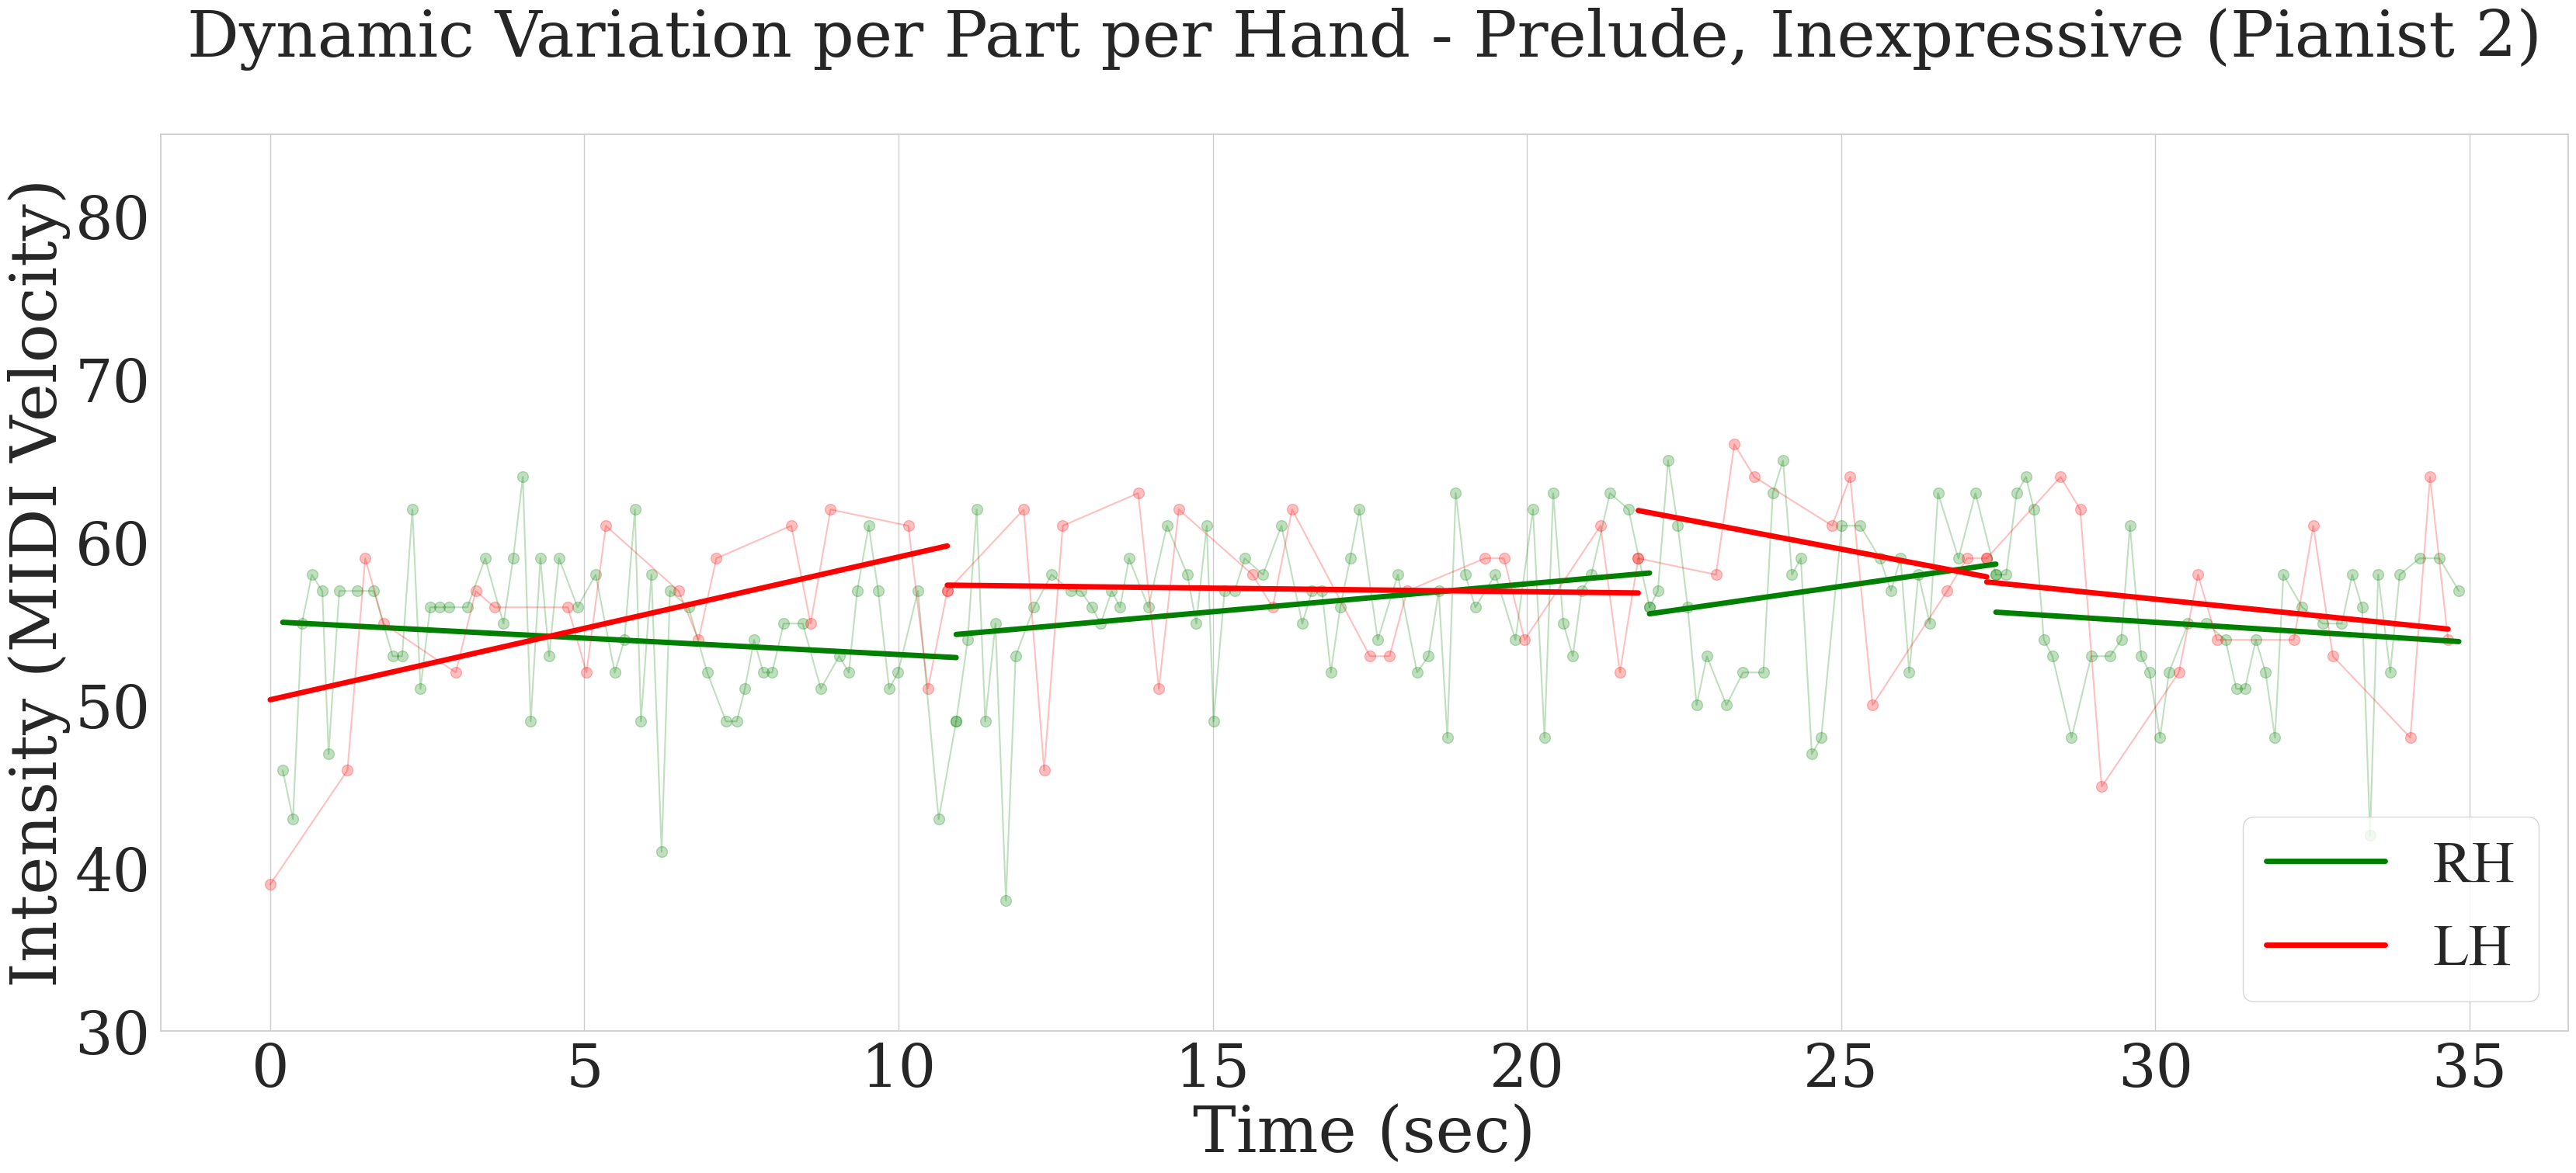

In [217]:
plot_dynamics_per_part_bach(df_midi, name, bach_parts, color_hand, fit_lr = True, cv_threshold = 0.1, 
                                slight_threshold = 4*10**(-3), threshold = 10**(-2))

In [218]:
def plot_dynamics_per_measure_bach(df, name, color_hand, fit_lr = False, cv_threshold = 0.1, 
                                slight_threshold = 4*10**(-3), threshold = 10**(-2)):
    
    df = df[df["Measure"]!=0] 
    
    sns.set(rc={'figure.figsize':(40,15)},font_scale=5)
    sns.set_style("whitegrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
    
    fig, ax = plt.subplots()
    
    start_time = df["Start Midi"].values[0]
    
    for m in range(1,21):
        
        for hand in ["RH","LH"]:
            
            print(20*'*', "HAND: ", hand,20*'*')

            df_midi_hand_part = df[df["Hand"]==hand]

            # right hand
            df_midi_hand_part = df_midi_hand_part[df_midi_hand_part['Measure']==m]
            df_midi_hand_part.reset_index(inplace=True, drop=True)


            df_midi_hand_part['Start Midi'] -= start_time
            
            df_midi_hand_part_lh = df_midi_hand_part[df_midi_hand_part["Hand"]=="LH"]
            df_midi_hand_part_rh = df_midi_hand_part[df_midi_hand_part["Hand"]=="RH"]
            
            
            plt.plot(df_midi_hand_part_lh['Start Midi'].values/framerate, df_midi_hand_part_lh['Velocity'].values, 
                     color = 'red', alpha = 0.25)
            plt.scatter(df_midi_hand_part_lh['Start Midi'].values/framerate, df_midi_hand_part_lh['Velocity'].values, 
                        color='red', alpha = 0.25, s = 100)
            
            plt.plot(df_midi_hand_part_rh['Start Midi'].values/framerate, df_midi_hand_part_rh['Velocity'].values, 
                     color = 'green', alpha = 0.25)            
            plt.scatter(df_midi_hand_part_rh['Start Midi'].values/framerate, df_midi_hand_part_rh['Velocity'].values, 
                        color='green', alpha = 0.25, s = 100)            

            if fit_lr:
                
                # plot asc
                reg = LinearRegression().fit(df_midi_hand_part['Start Midi'].values.reshape(-1, 1), 
                                             df_midi_hand_part['Velocity'].values)
                slope = reg.coef_
                intercept = reg.intercept_

                x = [df_midi_hand_part['Start Midi'].values[0]/framerate, df_midi_hand_part['Start Midi'].values[-1]/framerate]
                y = [slope*df_midi_hand_part['Start Midi'].values[0]+intercept, 
                     slope*df_midi_hand_part['Start Midi'].values[-1]+intercept]
                plt.plot(x, y, color = color_hand[hand], label = hand, linewidth = 5)
                
                print("Measure "+ str(m) +" has slope "+str(slope))

                cv = df_midi_hand_part.describe()['Velocity']['std']/df_midi_hand_part.describe()['Velocity']['mean']
                if (cv>cv_threshold):
                    print("Cannot decide")
                else:
                    if abs(slope[0]) < slight_threshold:
                        print("Level Sound")
                    elif slope[0]>0: 
                        if slope[0]>threshold:
                            print("Crescendo")
                        else: 
                            print("Slight Crescendo")
                    elif slope[0]<0:
                        if slope[0]<-threshold:
                            print("Diminuendo")                        
                        else:
                            print("Slight Diminuendo")                


    plt.ylim(30,85)
    ax.yaxis.grid(False) # Hide the horizontal gridlines
    ax.xaxis.grid(False) # Show the vertical gridlines    
    plt.title("Note Loudness per Measure - Bach "+str(type_dict[name]) +" (Pianist " + name[1] + ")", y=1.08)
    plt.xlabel('Time (sec)')
    plt.ylabel('Intensity (MIDI Velocity)')
    ax.legend()

    legend_without_duplicate_labels(ax)
    plt.savefig("./plots/dynamics/intensity_per_measure_"+ name+ "_per_hand.png")
    plt.show()
    plt.close()  

In [219]:
def plot_dynamics_per_measure_bach2(df, name, color_hand, fit_lr = False, cv_threshold = 0.1, 
                                slight_threshold = 4*10**(-3), threshold = 10**(-2)):
    
    df = df[df["Measure"]!=0] 
    
    sns.set(rc={'figure.figsize':(40,15)},font_scale=5)
    sns.set_style("whitegrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
    
    fig, ax = plt.subplots()
    
    start_time = df["Start Midi"].values[0]
    
    for m in range(1,21):
        
        for hand in ["RH","LH"]:
            
            print(20*'*', "HAND: ", hand,20*'*')

            df_midi_hand_part = df[df["Hand"]==hand]

            # right hand
            df_midi_hand_part = df_midi_hand_part[df_midi_hand_part['Measure']==m]
            df_midi_hand_part.reset_index(inplace=True, drop=True)


            df_midi_hand_part['Start Midi'] -= start_time
            
            df_midi_hand_part_lh = df_midi_hand_part[df_midi_hand_part["Hand"]=="LH"]
            df_midi_hand_part_rh = df_midi_hand_part[df_midi_hand_part["Hand"]=="RH"]
            
            
            plt.plot(df_midi_hand_part_lh['Start Midi'].values/framerate, df_midi_hand_part_lh['Velocity'].values, 
                     color = 'red', alpha = 0.25)
            plt.scatter(df_midi_hand_part_lh['Start Midi'].values/framerate, df_midi_hand_part_lh['Velocity'].values, 
                        color='red', alpha = 0.25, s = 100)
            
            plt.plot(df_midi_hand_part_rh['Start Midi'].values/framerate, df_midi_hand_part_rh['Velocity'].values, 
                     color = 'green', alpha = 0.25)            
            plt.scatter(df_midi_hand_part_rh['Start Midi'].values/framerate, df_midi_hand_part_rh['Velocity'].values, 
                        color='green', alpha = 0.25, s = 100)            

        if fit_lr:
            df_midi_hand_part = df[df["Measure"]==m]
            df_midi_hand_part['Start Midi'] -= start_time
            # plot asc
            reg = LinearRegression().fit(df_midi_hand_part['Start Midi'].values.reshape(-1, 1)/framerate, 
                                         df_midi_hand_part['Velocity'].values)
            slope = reg.coef_
            intercept = reg.intercept_

            x = [df_midi_hand_part['Start Midi'].values[0]/framerate, df_midi_hand_part['Start Midi'].values[-1]/framerate]
            y = [slope*df_midi_hand_part['Start Midi'].values[0]/framerate+intercept, 
                 slope*df_midi_hand_part['Start Midi'].values[-1]/framerate+intercept]
            plt.plot(x, y, color = "black", label = "Both Hands", linewidth = 5)

            print("Measure "+ str(m) +" has slope "+str(slope))

            cv = df_midi_hand_part.describe()['Velocity']['std']/df_midi_hand_part.describe()['Velocity']['mean']
            if (cv>cv_threshold):
                print("Cannot decide")
            else:
                if abs(slope[0]) < slight_threshold:
                    print("Level Sound")
                elif slope[0]>0: 
                    if slope[0]>threshold:
                        print("Crescendo")
                    else: 
                        print("Slight Crescendo")
                elif slope[0]<0:
                    if slope[0]<-threshold:
                        print("Diminuendo")                        
                    else:
                        print("Slight Diminuendo")                


    plt.ylim(30,85)
    ax.yaxis.grid(False) # Hide the horizontal gridlines
    ax.xaxis.grid(False) # Show the vertical gridlines    
    plt.title("Note Loudness per Measure - Bach "+str(type_dict[name]) +" (Pianist " + name[1] + ")", y=1.08)
    plt.xlabel('Time (sec)')
    plt.ylabel('Intensity (MIDI Velocity)')
    ax.legend()

    legend_without_duplicate_labels(ax)
    plt.savefig("./plots/dynamics/intensity_per_measure_"+ name+ "both_hands.png")
    plt.show()
    plt.close()  

******************** HAND:  RH ********************
Part Part 1 (m. 1-7) asc has slope [-0.20178698]
Diminuendo
******************** HAND:  LH ********************
Part Part 1 (m. 1-7) asc has slope [0.87579812]
Cannot decide
******************** HAND:  RH ********************
Part Part 2 (m. 7-13) asc has slope [0.34161494]
Crescendo
******************** HAND:  LH ********************
Part Part 2 (m. 7-13) asc has slope [-0.04352375]
Diminuendo
******************** HAND:  RH ********************
Part Part 3 (m. 13-16) asc has slope [0.55300697]
Crescendo
******************** HAND:  LH ********************
Part Part 3 (m. 13-16) asc has slope [-0.73346156]
Diminuendo
******************** HAND:  RH ********************
Part Part 4 (m. 16-20) asc has slope [-0.24481434]
Diminuendo
******************** HAND:  LH ********************
Part Part 4 (m. 16-20) asc has slope [-0.39392322]
Cannot decide


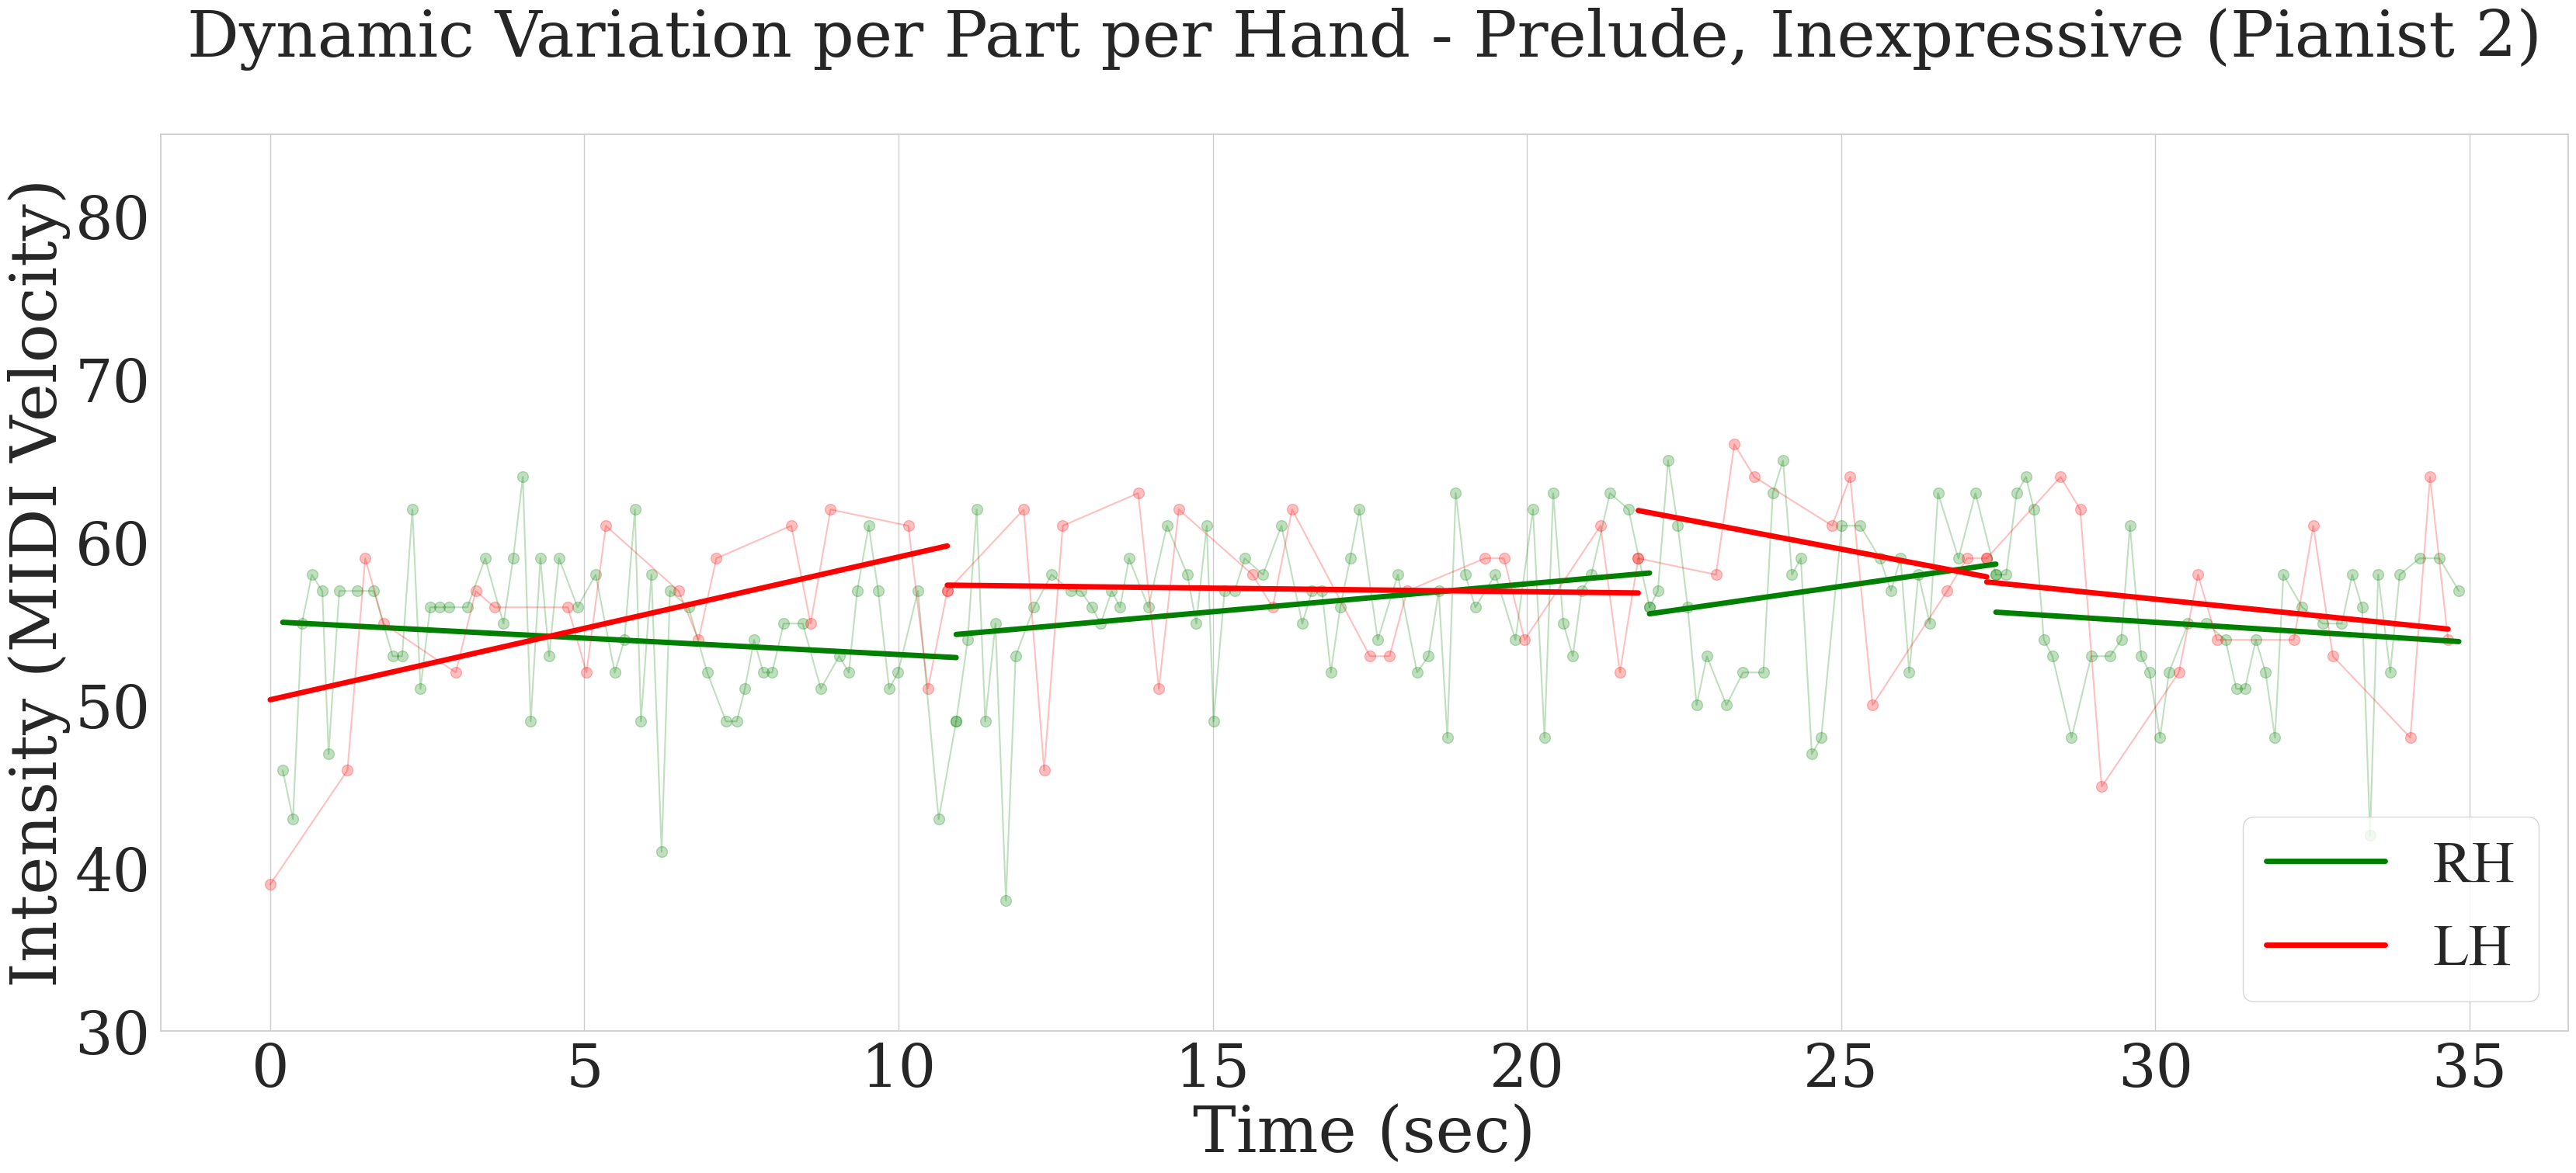

In [220]:
plot_dynamics_per_part_bach(df_midi, name, bach_parts, color_hand, 
                            fit_lr = True, cv_threshold = 0.1, 
                            slight_threshold = 4*10**(-3), threshold = 10**(-2))

******************** HAND:  RH ********************
Measure 1 has slope [0.03130567]
Cannot decide
******************** HAND:  LH ********************
Measure 1 has slope [0.04569462]
Cannot decide
******************** HAND:  RH ********************
Measure 2 has slope [0.01099621]
Crescendo
******************** HAND:  LH ********************
Measure 2 has slope [0.00124359]
Level Sound
******************** HAND:  RH ********************
Measure 3 has slope [-7.54190471e-05]
Level Sound
******************** HAND:  LH ********************
Measure 3 has slope [-0.00816872]
Slight Diminuendo
******************** HAND:  RH ********************
Measure 4 has slope [-0.00370546]
Cannot decide
******************** HAND:  LH ********************
Measure 4 has slope [-0.01832265]
Diminuendo
******************** HAND:  RH ********************
Measure 5 has slope [0.01059288]
Crescendo
******************** HAND:  LH ********************
Measure 5 has slope [-0.00604965]
Slight Diminuendo
********

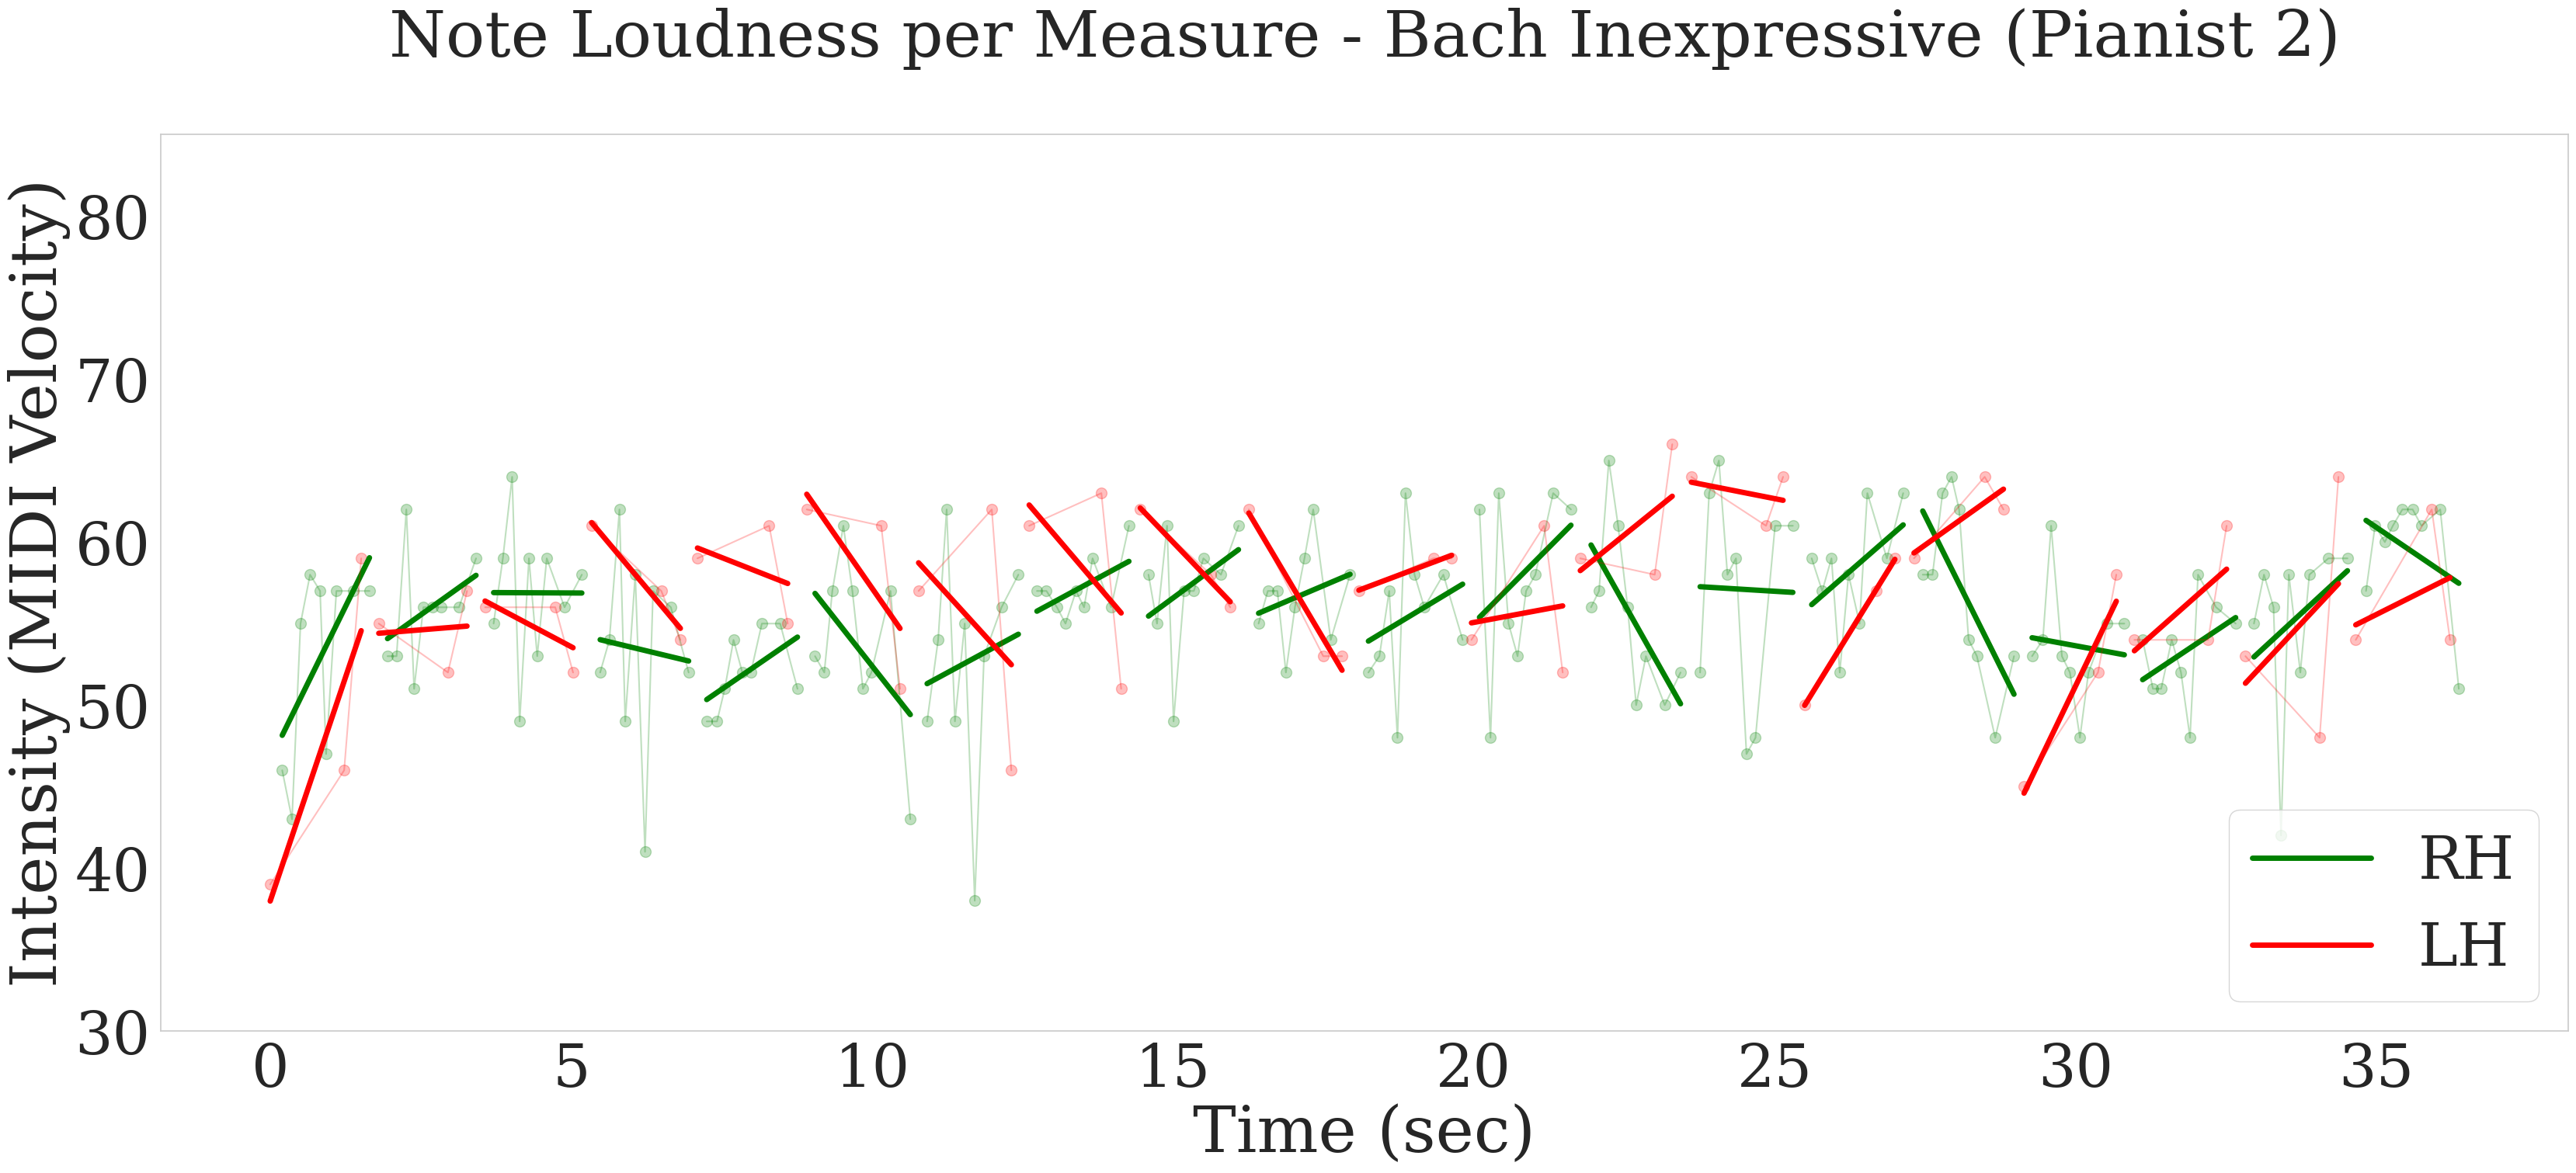

In [221]:
plot_dynamics_per_measure_bach(df_midi, name, color_hand, fit_lr = True, cv_threshold = 0.1, 
                                slight_threshold = 4*10**(-3), threshold = 10**(-2))

******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 1 has slope [8.68073314]
Cannot decide
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 2 has slope [1.65108742]
Crescendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 3 has slope [-0.9363169]
Diminuendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 4 has slope [-1.98163883]
Cannot decide
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 5 has slope [1.36955798]
Crescendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 6 has slope [-4.57865562]
Cannot decide
******************** HAND:  RH ********************
******************** HAND:  LH ********************

/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_midi_hand_part['Start Midi'] -= start_time
/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_midi_hand_part['Start Midi'] -= start_time
/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Diminuendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 9 has slope [0.28095476]
Crescendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 10 has slope [-1.63257936]
Diminuendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 11 has slope [2.05327128]
Crescendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 12 has slope [2.34331108]
Crescendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 13 has slope [-2.36929893]
Diminuendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 14 has slope [0.01233191]
Cannot decide
******************** HAND:  RH ********************
******************** HAND:  LH ***********

/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_midi_hand_part['Start Midi'] -= start_time
/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_midi_hand_part['Start Midi'] -= start_time
/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Diminuendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 17 has slope [2.47022045]
Crescendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 18 has slope [2.98355199]
Crescendo
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 19 has slope [3.56965891]
Cannot decide
******************** HAND:  RH ********************
******************** HAND:  LH ********************
Measure 20 has slope [-0.95650166]
Diminuendo


/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_midi_hand_part['Start Midi'] -= start_time
/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_midi_hand_part['Start Midi'] -= start_time
/var/folders/kk/qgsxf8111mq8qdv_kdqqd5wr0000gn/T/ipykernel_8641/938401827.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

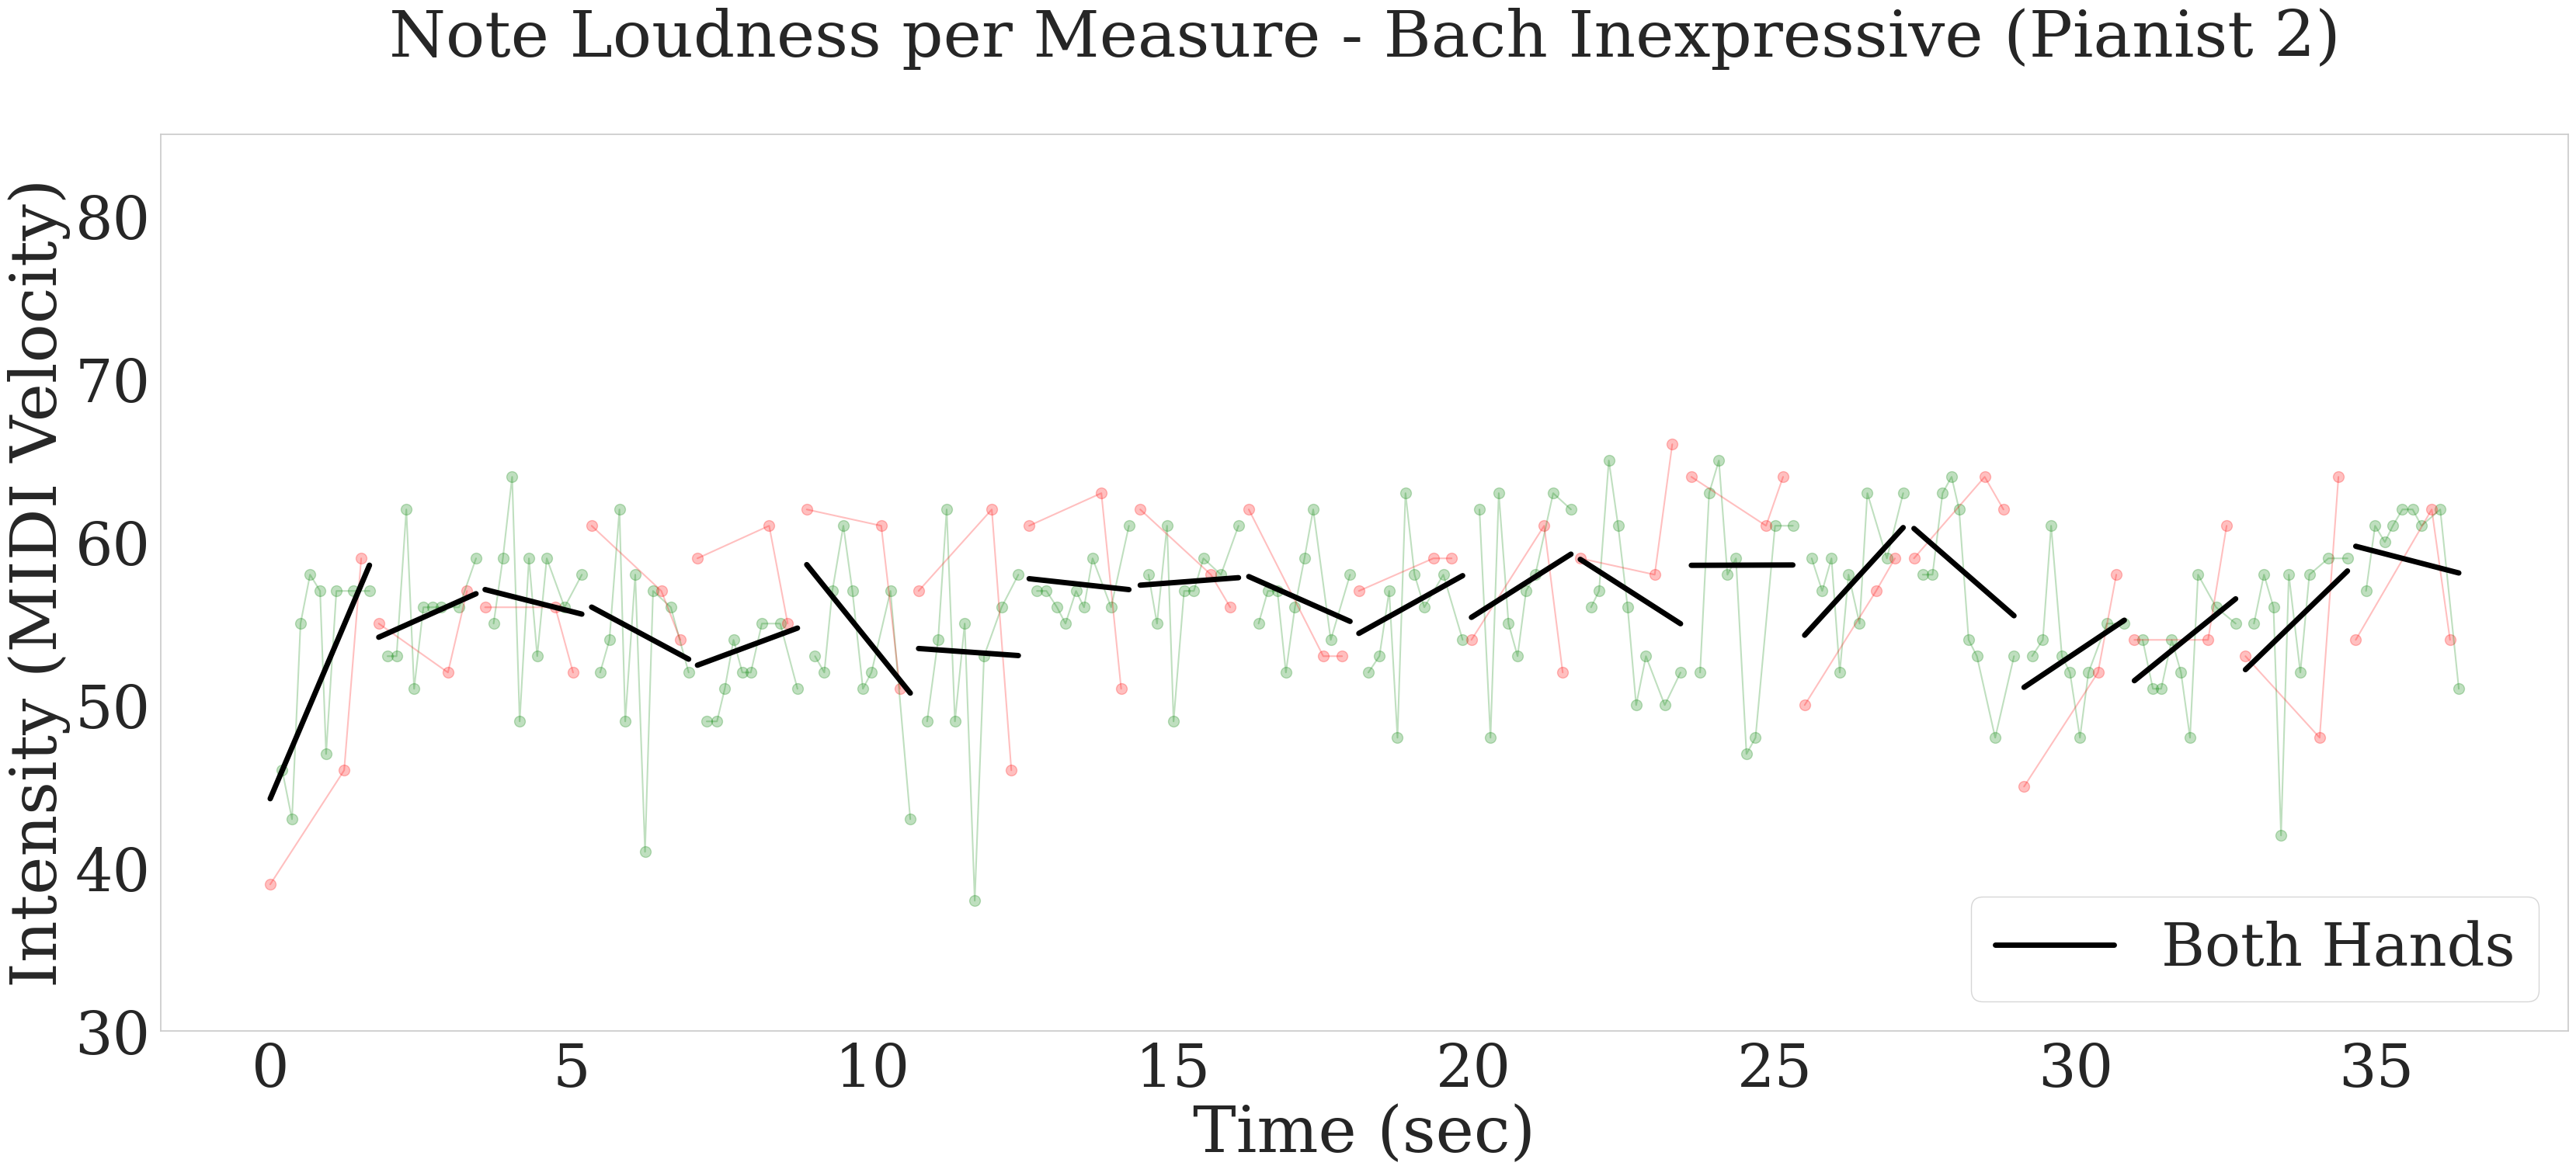

In [222]:
plot_dynamics_per_measure_bach2(df_midi, name, color_hand, fit_lr = True, cv_threshold = 0.1, 
                                slight_threshold = 4*10**(-3), threshold = 10**(-2))